## Siemens FDA

**Index**

1. Loading the datasets
2. Transposing the time series datasets
3. Merging time series datasets to add additional features
4. Filtering and spliting in Blood and aqueous groups
5. Window extraction
   - 5.1. Validating if there are partial or full missing values after the extraction
   - 5.2 Visualize the origin window intervals in different groups of Features
6. Additional Functions
   7.1. Visualization of plots with raw data after the extraction.
   7.2. Visualization of plots with data centered after the extraction.
7. Visualization of Time Series from the Windows
8. Functional PCA (Visualization of Principal Component Plots in one row)
    - 8.1. Functional PCA characterization function
    - 8.2 Functional PC1 plots (both systems)  Characterization of FPC Scores
    - 8.3 Linear Reregression
9. Fuctional regression
     

The improvements with respect to the code "Siemens_FDA.ipynb" are:
- Change the part in "Filtering and spliting in Bloods and Aqueous groups" for sample the data
- Change the "Merge data" Function in "Additional functions"
- Add 8.3 "Linear Regression" to make statistic summary for PCA(still developing)
- Update 7.2 function "plot_all_time_series_in_group" with a new function to save the photos

# 1. Loading the datasets

In [1]:
#!pip install scikit-fda

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import random
from sklearn.decomposition import PCA
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.projection import FPCA
from sklearn.preprocessing import OneHotEncoder
import skfda
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import FDataBasis, FourierBasis

/var/folders/_c/wdm33bq11dvflh73ffxrd8z40000gn/T/ipykernel_5354/2677705551.py:9: DeprecationWarning: The module "projection" is deprecated. Please use "dim_reduction"
  from skfda.preprocessing.dim_reduction.projection import FPCA


# 2. Transposing the time series datasets

You can change this part based on where you store the data

In [3]:
# # Import datasets
sensorA_System1 = pd.read_csv("RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("RawData/System2_SensorB.csv")
sensorA_System1_missing = pd.read_csv("RawData/SensorA_System1_missing values.csv")
sensorA_System2_missing = pd.read_csv("RawData/SensorA_System2_missing values.csv")
keyByTestID = pd.read_csv("RawData/Key by TestID.csv", parse_dates=['DateTime'])

# Import datasets
#sensorA_System1 = pd.read_csv("../../../RawData/System1_SensorA.csv")
#sensorA_System2 = pd.read_csv("../../../RawData/System2_SensorA.csv")
#sensorB_System1 = pd.read_csv("../../../RawData/System1_SensorB.csv")
#sensorB_System2 = pd.read_csv("../../../RawData/System2_SensorB.csv")
#sensorA_System1_missing = pd.read_csv("../../../RawData/SensorA_System1_missing values.csv")
#sensorA_System2_missing = pd.read_csv("../../../RawData/SensorA_System2_missing values.csv")
#keyByTestID = pd.read_csv("../../../RawData/Key by TestID.csv", parse_dates=['DateTime'])

# 3. Merging time series datasets to add additional features

In [4]:
# Transpose dataset to make columns as timestamps and rows as tests

# Sensor A
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

A1_missing_transposed = sensorA_System1_missing.T.reset_index()
A1_missing_transposed.columns = A1_missing_transposed.iloc[0]
A1_missing_transposed.rename(columns={A1_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A1_missing_transposed = A1_missing_transposed.drop(0)
A1_missing_transposed['TestID'] = A1_missing_transposed['TestID'].astype(int)

A2_missing_transposed = sensorA_System2_missing.T.reset_index()
A2_missing_transposed.columns = A2_missing_transposed.iloc[0]
A2_missing_transposed.rename(columns={A2_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A2_missing_transposed = A2_missing_transposed.drop(0)
A2_missing_transposed['TestID'] = A2_missing_transposed['TestID'].astype(int)

# Sensor B
B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [5]:
# Complete A1 and A2 with the missing values
A1_transposed_mid = A1_transposed[~A1_transposed.TestID.isin(A1_missing_transposed.TestID)]
A1_transposed = pd.concat([A1_transposed_mid, A1_missing_transposed], axis=0)
A2_transposed_mid = A2_transposed[~A2_transposed.TestID.isin(A2_missing_transposed.TestID)]
A2_transposed = pd.concat([A2_transposed_mid, A2_missing_transposed], axis=0)

In [6]:
# Create new column to fill fluid temperature NA's
# Note: Fluid temperature: If specified, take as the temperature of the sample fluid. The rest of the system temperature can be taken as ambient temperature.

keyByTestID['Fluid_Temperature_Filled'] = keyByTestID['Fluid Temperature'].combine_first(keyByTestID['AmbientTemperature'])
keyByTestID.head(3)

,TestID,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode,Fluid_Temperature_Filled
0,3550995,Eurotrol L1,2024-02-07 10:32:15,16-23333-20,302910,70,73,180.4,178.8,System 2A,Sensor A,21.2345,NaN,NaN,Success,NoError,NoError,Success,21.2345
1,3550995,Eurotrol L1,2024-02-07 10:32:15,16-23333-20,302910,70,73,180.4,178.8,System 2A,Sensor B,21.2345,NaN,NaN,Success,NoError,NoError,Success,21.2345
2,3551012,Eurotrol L1,2024-02-07 10:41:33,16-23333-20,303096,70,73,183.2,181.6,System 2A,Sensor A,21.5012,NaN,NaN,Success,NoError,NoError,Success,21.5012


In [7]:
# Relabeling System Values
keyByTestID["System"] = keyByTestID["System"].replace({"System 2A":"System 2","System 2B":"System 2"})
keyByTestID.tail(3)

,TestID,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode,Fluid_Temperature_Filled
24255,3518677,HNB,2023-09-19 16:54:21,16-23151-20,302186,111,23,459.0,454.8,System 2,Sensor B,25.2250,15.0,NaN,Success,NoError,NoError,Success,15.0
24256,3518678,HNB,2023-09-19 16:54:23,16-23137-20,300820,125,33,459.2,455.2,System 2,Sensor A,24.4908,15.0,NaN,Success,NoError,NoError,Success,15.0
24257,3518678,HNB,2023-09-19 16:54:23,16-23137-20,300820,125,33,459.2,455.2,System 2,Sensor B,24.4908,15.0,NaN,Success,NoError,NoError,Success,15.0


In [8]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3382, 3377)
A2:  (7743, 3368)
B1:  (3375, 3377)
B2:  (7745, 3368)


In [9]:
# Remove the testID only exists in one sensor
# Only run once
A1_Merged = A1_Merged[A1_Merged["TestID"].isin(B1_Merged["TestID"])]
B1_Merged = B1_Merged[B1_Merged["TestID"].isin(A1_Merged["TestID"])]

A2_Merged = A2_Merged[A2_Merged["TestID"].isin(B2_Merged["TestID"])]
B2_Merged = B2_Merged[B2_Merged["TestID"].isin(A2_Merged["TestID"])]
print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3374, 3377)
A2:  (7743, 3368)
B1:  (3374, 3377)
B2:  (7743, 3368)


In [10]:
attribute_column='AmbientTemperature'
bin_column_name='AmbTempBin'
bins=[-1, 20, 26, 100]
labels=['Below 20', '20-26', 'Above 26']
data = A1_Merged
# Discretize the temperature values into bins and assign labels
data[bin_column_name] = pd.cut(data[attribute_column], bins=bins, labels=labels)
    
    # # Calculate the proportions of each bin
bin_counts = data['AmbTempBin'].value_counts()
bin_proportions = bin_counts / bin_counts.sum()

In [11]:
bin_proportions

20-26       0.975697
Above 26    0.014523
Below 20    0.009781
Name: AmbTempBin, dtype: float64

In [12]:
bin_counts

20-26       3292
Above 26      49
Below 20      33
Name: AmbTempBin, dtype: int64

# 4. Filtering and spliting in Blood and Aqueous groups

In [13]:
def balance_by_attribute(data, attribute_column='AmbientTemperature', bin_column_name='AmbTempBin', bins=[-1, 20, 26, 100], labels=['Below 20', '20-26', 'Above 26'], total_size=None, random_state=42):
    """
    Balances the dataset based on the attribute bins, taking the total data size into account.

    Parameters:
    data (pd.DataFrame): The input dataset.
    temperature_column (str): The column name for the attribute.
    bins (list): The bin edges for discretizing attribute.
    labels (list): The labels for the bins.
    total_size (int): The desired total size of the balanced dataset. If None, the function will balance the data based on the minimum bin size.
    random_state (int): The seed for the random number generator to ensure reproducibility.

    Returns:
    pd.DataFrame: The balanced dataset.
    """
    # Discretize the attribute values into bins and assign labels
    data[bin_column_name] = pd.cut(data[attribute_column], bins=bins, labels=labels)
    
    # # Calculate the proportions of each bin
    #bin_counts = data['bin_column_name'].value_counts()
    #bin_proportions = bin_counts / bin_counts.sum()
    
    #if total_size is None:
        #If total_size is not provided, use the minimum bin size to balance
        #min_count = bin_counts.min()
        #total_size = min_count * len(bin_counts)
    
    # Calculate the number of samples to draw from each bin
    #sample_sizes = (bin_proportions * total_size).round().astype(int)
    
    # Sample the data from each bin
    #balanced_data = data.groupby(bin_column_name).apply(lambda x: x.sample(n=min(sample_sizes[x.name], len(x)), random_state=random_state)).reset_index(drop=True)
    
    # Calculate the minimum bin size to ensure equal sample sizes
    #min_count = data[bin_column_name].value_counts().min()
    
    # Sample the data from each bin
    balanced_data = data.groupby(bin_column_name).apply(lambda x: x.sample(n=33, random_state=random_state)).reset_index(drop=True)
    return balanced_data

# Balance by temperature
# A1_Merged_balanced = balance_by_temperature(A1_Merged, total_size=3000)
# A2_Merged_balanced = balance_by_temperature(A2_Merged, total_size=3000)
# B1_Merged_balanced = balance_by_temperature(B1_Merged, total_size=3000)
# B2_Merged_balanced = balance_by_temperature(B2_Merged, total_size=3000)

A1_Merged_balanced = balance_by_attribute(A1_Merged)
A2_Merged_balanced = balance_by_attribute(A2_Merged)
B1_Merged_balanced = balance_by_attribute(B1_Merged)
B2_Merged_balanced = balance_by_attribute(B2_Merged)

print("A1_Merged_balanced shape:", A1_Merged_balanced.shape)
print("A2_Merged_balanced shape:", A2_Merged_balanced.shape)
print("B1_Merged_balanced shape:", B1_Merged_balanced.shape)
print("B2_Merged_balanced shape:", B2_Merged_balanced.shape)


A1_Merged_balanced shape: (99, 3378)
A2_Merged_balanced shape: (99, 3369)
B1_Merged_balanced shape: (99, 3378)
B2_Merged_balanced shape: (99, 3369)


In [14]:
def inspect_bins(data, attribute_column='AmbientTemperature', bin_column_name='AmbTempBin', bins=[-1, 20, 26, 100], labels=['Below 20', '20-26', 'Above 26']):
    """
    Inspects the distribution of samples across temperature bins.

    Parameters:
    data (pd.DataFrame): The input dataset.
    temperature_column (str): The column name for fluid temperature.
    bins (list): The bin edges for discretizing temperature.
    labels (list): The labels for the bins.

    Returns:
    pd.Series: The count of samples in each temperature bin.
    """
    data[bin_column_name] = pd.cut(data[attribute_column], bins=bins, labels=labels)
    return data[bin_column_name].value_counts()

# Example inspection
print("A1_Merged_balanced distribution:\n", inspect_bins(A1_Merged_balanced))
print("A2_Merged_balanced distribution:\n", inspect_bins(A2_Merged_balanced))
print("B1_Merged_balanced distribution:\n", inspect_bins(B1_Merged_balanced))
print("B2_Merged_balanced distribution:\n", inspect_bins(B2_Merged_balanced))


A1_Merged_balanced distribution:
 Below 20    33
20-26       33
Above 26    33
Name: AmbTempBin, dtype: int64
A2_Merged_balanced distribution:
 Below 20    33
20-26       33
Above 26    33
Name: AmbTempBin, dtype: int64
B1_Merged_balanced distribution:
 Below 20    33
20-26       33
Above 26    33
Name: AmbTempBin, dtype: int64
B2_Merged_balanced distribution:
 Below 20    33
20-26       33
Above 26    33
Name: AmbTempBin, dtype: int64


# 5. Window extraction

In [15]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Define a function to calculate window start and end values
def calculate_window_values(bubble_start, sample_start, calDelimit_input, cal_window_size_input, sampleDelimit_input, sample_window_size_input):
    """
    Calculate the start and end values for calibration and sample windows. The calculation is based on given start points and delimiters for both windows, as well as the window sizes.

    Parameters:
    -----------
    bubble_start : float
        The starting point for the bubble (reference point for calibration).
    sample_start : float
        The starting point for the sample.
    calDelimit_input : float
        The delimiter value to adjust the starting point of the calibration window.
    cal_window_size_input : float
        The size of the calibration window.
    sampleDelimit_input : float
        The delimiter value to adjust the starting point of the sample window.
    sample_window_size_input : float
        The size of the sample window.

    Returns:
    --------
    tuple of float
        A tuple containing four values:
        - cal_window_start: The starting position of the calibration window, rounded to one decimal place.
        - cal_window_end: The ending position of the calibration window, rounded to one decimal place.
        - sample_window_start: The starting position of the sample window, rounded to one decimal place.
        - sample_window_end: The ending position of the sample window, rounded to one decimal place.
    """
    cal_window_start = bubble_start - calDelimit_input
    cal_window_end = cal_window_start + cal_window_size_input
    sample_window_start = sample_start + sampleDelimit_input
    sample_window_end = sample_window_start + sample_window_size_input
    return round(cal_window_start,1), round(cal_window_end,1), round(sample_window_start,1), round(sample_window_end,1)

# Sensor A
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_Merged_balanced['BubbleDetectTime'],
                                                                                                   sample_start=A1_Merged_balanced['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_Merged_balanced['cal_window_start']=cal_window_start
A1_Merged_balanced['cal_window_end']=cal_window_end
A1_Merged_balanced['sample_window_start']=sample_window_start
A1_Merged_balanced['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged_balanced['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged_balanced['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_Merged_balanced['cal_window_start']=cal_window_start
A2_Merged_balanced['cal_window_end']=cal_window_end
A2_Merged_balanced['sample_window_start']=sample_window_start
A2_Merged_balanced['sample_window_end']=sample_window_end


# sensor B

# Match window values of Sensor B for each test
calDelimit = 20
cal_window_size = 18
sampleDelimit_blood = 24
sampleDelimit_aqueous = 30
sample_window_size = 4

B1_Merged_balanced['cal_window_start'], B1_Merged_balanced['cal_window_end'], \
B1_Merged_balanced['sample_window_start'], B1_Merged_balanced['sample_window_end'] = zip(*B1_Merged_balanced.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit_input=calDelimit,
        cal_window_size_input=cal_window_size,
        sampleDelimit_input=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size_input=sample_window_size
    ),
    axis=1
))

# For sensor B in system 2, blood and aqueous
B2_Merged_balanced['cal_window_start'], B2_Merged_balanced['cal_window_end'], \
B2_Merged_balanced['sample_window_start'], B2_Merged_balanced['sample_window_end'] = zip(*B2_Merged_balanced.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit_input=calDelimit,
        cal_window_size_input=cal_window_size,
        sampleDelimit_input=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size_input=sample_window_size
    ),
    axis=1
))


In [16]:
# Define a function to extract window data of each test
def calculate_window_data(row):
    """
    Extracts calibration and sample window data from a given row of time series data.

    Parameters:
    row (pd.Series): A pandas Series object containing time series data and window start/end times.
        The Series should have the following structure:
        - 'cal_window_start': The start time for the calibration window.
        - 'cal_window_end': The end time for the calibration window.
        - 'sample_window_start': The start time for the sample window.
        - 'sample_window_end': The end time for the sample window.
        - The index from position 19 to -4 should contain the timestamps (as float) of the time series data.

    Returns:
    tuple: A tuple containing two pandas Series:
        - The first Series corresponds to the data within the calibration window.
        - The second Series corresponds to the data within the sample window.
    """
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[19:-5].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window],row[sample_window]

# System 1 - Sensor A

A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged_balanced)):
    cal_window, sample_window = calculate_window_data(A1_Merged_balanced.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged_balanced['TestID'].astype(int)
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A

A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged_balanced)):
    cal_window, sample_window = calculate_window_data(A2_Merged_balanced.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged_balanced['TestID'].astype(int)
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B

B1_cal_window = []
B1_sample_window = []
for i in range(len(B1_Merged_balanced)):
    cal_window, sample_window = calculate_window_data(B1_Merged_balanced.iloc[i, :])
    B1_cal_window.append(cal_window.values)
    B1_sample_window.append(sample_window.values)
B1_cal_window = pd.DataFrame(B1_cal_window)
B1_sample_window = pd.DataFrame(B1_sample_window)
B1_cal_window['TestID'] = B1_sample_window['TestID'] = B1_Merged_balanced['TestID'].astype(int)
B1_sample_window.set_index('TestID',inplace=True)
B1_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor B

B2_cal_window = []
B2_sample_window = []
for i in range(len(B2_Merged_balanced)):
    cal_window, sample_window = calculate_window_data(B2_Merged_balanced.iloc[i, :])
    B2_cal_window.append(cal_window.values)
    B2_sample_window.append(sample_window.values)
B2_cal_window = pd.DataFrame(B2_cal_window)
B2_sample_window = pd.DataFrame(B2_sample_window)
B2_cal_window['TestID'] = B2_sample_window['TestID'] = B2_Merged_balanced['TestID'].astype(int)
B2_sample_window.set_index('TestID',inplace=True)
B2_cal_window.set_index('TestID',inplace=True)

## 5.1. Validating if there are partial or full missing values after the extraction

In [17]:
A1_cal_window_drop_index = A1_cal_window.loc[A1_cal_window.isna().sum(axis=1)!=0].index
A2_cal_window_drop_index = A2_cal_window.loc[A2_cal_window.isna().sum(axis=1)!=0].index

A1_sample_window_drop_index = A1_sample_window.loc[A1_sample_window.isna().sum(axis=1)!=0].index
A2_sample_window_drop_index = A2_sample_window.loc[A2_sample_window.isna().sum(axis=1)!=0].index

B1_cal_window_drop_index = B1_cal_window.loc[B1_cal_window.isna().sum(axis=1)!=0].index
B2_cal_window_drop_index = B2_cal_window.loc[B2_cal_window.isna().sum(axis=1)!=0].index

B1_sample_window_drop_index = B1_sample_window.loc[B1_sample_window.isna().sum(axis=1)!=0].index
B2_sample_window_drop_index = B2_sample_window.loc[B2_sample_window.isna().sum(axis=1)!=0].index

# Check if missing values in different windows is different
print("The missing value in calibration window:",A1_cal_window_drop_index)
print("The missing value in sample window:",A1_sample_window_drop_index)
print("The missing value in calibration window:",A2_cal_window_drop_index)
print("The missing value in sample window:",A2_sample_window_drop_index)

print("The missing value in calibration window:",B1_cal_window_drop_index)
print("The missing value in sample window:",B1_sample_window_drop_index)
print("The missing value in calibration window:",B2_cal_window_drop_index)
print("The missing value in sample window:",B2_sample_window_drop_index)

The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([], dtype='int64', name='TestID')
The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([], dtype='int64', name='TestID')
The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([], dtype='int64', name='TestID')
The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([], dtype='int64', name='TestID')


In [18]:
# Shape of the subsets of time series after the extraction from the windows

# Cal Window
print('Shape of the time series after extraction')
print('A1_cal_window: ', A1_cal_window.shape)
print('A2_cal_window: ', A2_cal_window.shape)
print('B1_cal_window: ', B1_cal_window.shape)
print('B2_cal_window: ', B2_cal_window.shape)

# Sample Window
print('A1_sample_window: ', A1_sample_window.shape)
print('A2_sample_window: ', A2_sample_window.shape)
print('B1_sample_window: ', B1_sample_window.shape)
print('B2_sample_window: ', B2_sample_window.shape)

Shape of the time series after extraction
A1_cal_window:  (99, 41)
A2_cal_window:  (99, 41)
B1_cal_window:  (99, 91)
B2_cal_window:  (99, 91)
A1_sample_window:  (99, 26)
A2_sample_window:  (99, 26)
B1_sample_window:  (99, 21)
B2_sample_window:  (99, 21)



# 6. Additional functions

In [19]:
def plot_all_time_series(df, title):
    """
    Plots all time series data from a DataFrame.

    Parameters:
    df (pd.DataFrame): A pandas DataFrame where each row represents a time series. The values in the rows are the
                       data points of the time series.
    title (str): The title for the plot.

    Returns:
    Display the chart with all the time series in one plot.
    """
    plt.figure(figsize=(6, 4))

    # Generate colors using a colormap
    num_lines = len(df)
    colors = plt.cm.Greys(np.linspace(0, 1, num_lines))

    # Plot each row with a different color
    for index, (i, row) in enumerate(df.iterrows()):
        plt.plot(row.values, label=f'Time Series {i + 1}', color=colors[index])

    plt.ylabel('Electrical signals (mV)')
    plt.xlabel('Time (s)')
    plt.title(title)
    plt.show()

In [20]:
def plot_all_time_series_and_mean_fpca(df, title, x_new, y_new):
    """
    Plots all time series data from a DataFrame and adds a new curve.

    Parameters:
    df (pd.DataFrame): A pandas DataFrame where each row represents a time series. The values in the rows are the
                       data points of the time series.
    title (str): The title for the plot.
    x_new (array-like): The x values for the mean from the fpca.
    y_new (array-like): The y values for the mean from the fpca.

    Returns:
    Displays the chart with all the time series and the new curve in one plot.
    """
    plt.figure(figsize=(6, 4))

    # Generate colors using a colormap
    num_lines = len(df)
    colors = plt.cm.Greys(np.linspace(0, 1, num_lines))

    # Plot each row with a different color
    for index, (i, row) in enumerate(df.iterrows()):
        plt.plot(row.values, label=f'Time Series {i + 1}', color=colors[index])

    # Add the new curve
    plt.plot(x_new, y_new, label='New Curve', color='red', linewidth=2)
    #plt.legend(title="Mean") 
    plt.ylabel('Electrical signals (mV)')
    plt.xlabel('Time (s)')
    plt.title(title)
    plt.show()

In [21]:
def plot_all_time_series_in_group(df1, df2, df3, df4, lab, name1, name2, name3, name4):
    """
    Plot time series data from four dataframes in a 2x2 grid of subplots.

    Parameters:
    df1 (DataFrame): The first dataframe containing time series data.
    df2 (DataFrame): The second dataframe containing time series data.
    df3 (DataFrame): The third dataframe containing time series data.
    df4 (DataFrame): The fourth dataframe containing time series data.
    lab (str): The column name used for labeling the series.
    name1 (str): The title for the first subplot.
    name2 (str): The title for the second subplot.
    name3 (str): The title for the third subplot.
    name4 (str): The title for the fourth subplot.

    Returns:
    None: This function displays the plots of the time series data.
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # Create a 2x2 grid of subplots

    # Create a color mapping for each unique label
    unique_labels = sorted(pd.concat([df1[lab], df2[lab], df3[lab], df4[lab]]).unique())
    colors = {label: plt.cm.tab10(i) for i, label in enumerate(unique_labels)}

    def plot_time_series(df, ax, subplot_title):
        """
        Plot the time series data on a given axis with a specified title.

        Parameters:
        df (DataFrame): The dataframe containing time series data.
        ax (Axes): The subplot axis to plot on.
        subplot_title (str): The title for the subplot.

        Returns:
        None
        """
        for index, row in df.iterrows():
            label = row[lab]
            ax.plot(range(len(row) - 6), row[:-6], label=label, color=colors[label])
        ax.set_ylabel('Electrical signals (mV)')
        ax.set_xlabel('Time (s)')

        # Create a unique legend with fixed order
        handles, labels = ax.get_legend_handles_labels()
        legend_handles = [handles[labels.index(label)] for label in unique_labels if label in labels]

        ax.legend(legend_handles, unique_labels, title=f'{lab}')
        ax.set_title(subplot_title)

    # Plot time series data for each dataframe in the respective subplot
    plot_time_series(df1, axs[0, 0], f'{name1}')
    plot_time_series(df2, axs[0, 1], f'{name2}')
    plot_time_series(df3, axs[1, 0], f'{name3}')
    plot_time_series(df4, axs[1, 1], f'{name4}')

    # Set the overall title for the figure
    fig.suptitle(f'Windows series in different {lab}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
    plt.savefig(f'{name1}.png')
    plt.show()


In [22]:
def Merge_data(windows, merge_data):
    """
    Merge the 'windows' dataframe with selected columns from the 'merge' dataframe,
    categorize 'AgeOfCardInDaysAtTimeOfTest' and 'AmbientTemperature' into bins,
    and return a random sample of the combined dataframe.

    Parameters:
    windows (DataFrame): The primary dataframe to merge.
    merge (DataFrame): The dataframe containing the additional columns to merge.

    Returns:
    DataFrame: A random sample of 500 rows from the merged dataframe.
    """

    # Merge the two dataframes on their indices
    window_combine = windows.merge(
        merge_data[["FluidType", "AgeOfCardInDaysAtTimeOfTest", "AmbientTemperature"]],
        how="inner",
        left_index=True,
        right_index=True
    )

    # Categorize 'AgeOfCardInDaysAtTimeOfTest' into bins
    window_combine["AgeBin"] = pd.cut(
        window_combine["AgeOfCardInDaysAtTimeOfTest"],
        bins=[0, 9, 28, 56, 84, 112, 140, 168, 196, 224, 252],
        labels=['Below 9', '9-28', '28-56', '56-84', '84-112', '112-140', '140-168', '168-196', '196-224', '224-252']
    )

    window_combine["AmbTempBin"] = pd.cut(
        window_combine["AmbientTemperature"],
        bins=[-1, 20, 26, 100], 
        labels=['Below 20', '20-26', 'Above 26']
    )

    # Categorize 'FluidType' into Blood and Aqueous
    window_combine['FluidTypeBin'] = np.where(window_combine['FluidType'].str.startswith('Eurotrol'), 'Aqueous', 'Blood')

    return window_combine


# 7. Visualization of Time Series from the Windows


## 7.1 Combination of the time series and features in the same table

We have the xx_xx_window (e.g. B2_blood_cal_window) variable which contains the time series value and also xx_Merged (e.g. A1_Merged) which includes the features [Card_Age, Temperature, Fluid_Type].

 In the following part, we try to combine them for the visualization and regression

In [23]:
# Set index for Merge datasets
A1_Merged_balanced.set_index("TestID", inplace=True)
A2_Merged_balanced.set_index("TestID", inplace=True)
B1_Merged_balanced.set_index("TestID", inplace=True)
B2_Merged_balanced.set_index("TestID", inplace=True)

In [24]:
# Combine data
A1_cal_window_combine = Merge_data(A1_cal_window,A1_Merged_balanced)
A2_cal_window_combine = Merge_data(A2_cal_window,A2_Merged_balanced)

B1_cal_window_combine = Merge_data(B1_cal_window,B1_Merged_balanced)
B2_cal_window_combine = Merge_data(B2_cal_window,B2_Merged_balanced)

A1_cal_window_combine = Merge_data(A1_cal_window,A1_Merged_balanced)
A2_cal_window_combine = Merge_data(A2_cal_window,A2_Merged_balanced)

B1_cal_window_combine = Merge_data(B1_cal_window,B1_Merged_balanced)
B2_cal_window_combine = Merge_data(B2_cal_window,B2_Merged_balanced)

## Sample window
A1_sample_window_combine = Merge_data(A1_sample_window,A1_Merged_balanced)
A2_sample_window_combine = Merge_data(A2_sample_window,A2_Merged_balanced)

B1_sample_window_combine = Merge_data(B1_sample_window,B1_Merged_balanced)
B2_sample_window_combine = Merge_data(B2_sample_window,B2_Merged_balanced)

In [25]:
#columns_to_drop = ['FluidType','AgeOfCardInDaysAtTimeOfTest','AgeBin', 'Fluid_Temperature_Filled', 'FluidTempBin','FluidTypeBin']
#A1_cal_window_combine.drop(columns=columns_to_drop, inplace=True)
#A2_cal_window_combine.drop(columns=columns_to_drop, inplace=True)
#B1_cal_window_combine.drop(columns=columns_to_drop, inplace=True)
#B2_cal_window_combine.drop(columns=columns_to_drop, inplace=True) 
#A1_sample_window_combine.drop(columns=columns_to_drop, inplace=True) 
#A2_sample_window_combine.drop(columns=columns_to_drop, inplace=True) 
#B1_sample_window_combine.drop(columns=columns_to_drop, inplace=True) 
#B2_sample_window_combine.drop(columns=columns_to_drop, inplace=True) 

## 7.2 Visualize the windows using the center data (scaling type 1)

### 7.2.1 Temperature

#### System 1 and System 2: Sensor A - Cal and Sample Windows

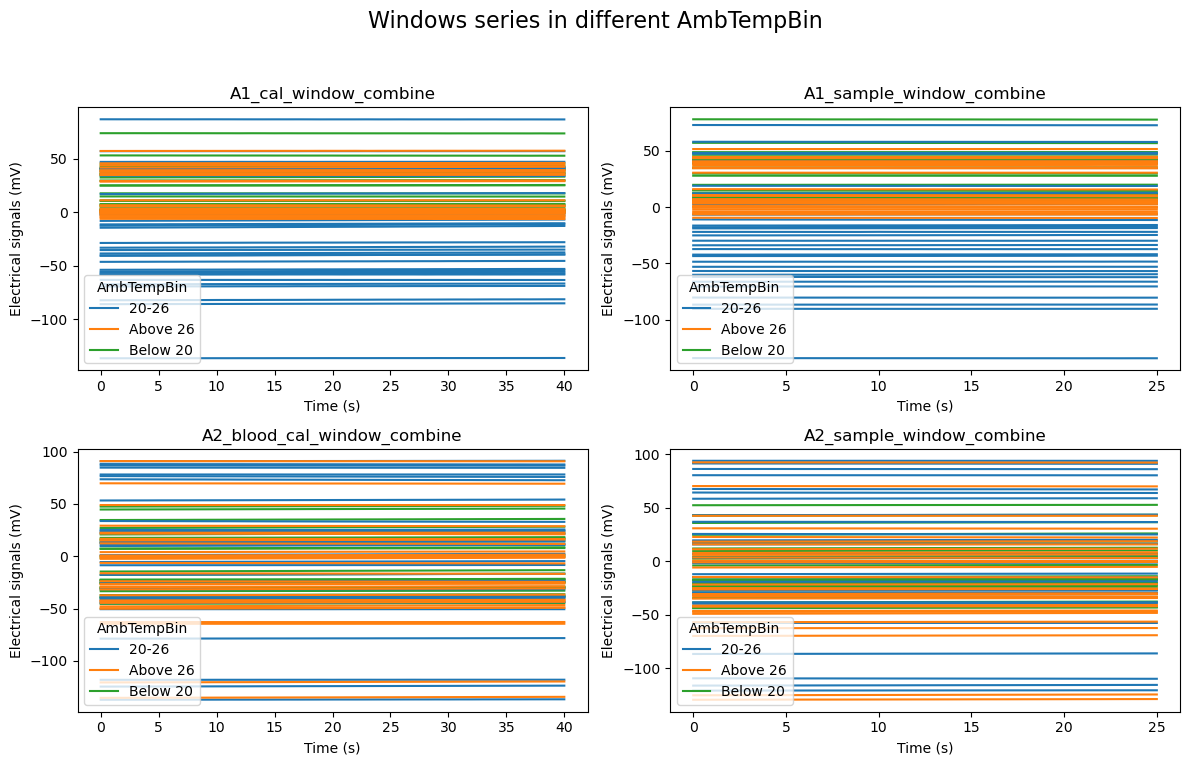

In [26]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(A1_cal_window_combine, A1_sample_window_combine, A2_cal_window_combine, A2_sample_window_combine,"AmbTempBin","A1_cal_window_combine", "A1_sample_window_combine","A2_blood_cal_window_combine", "A2_sample_window_combine")

#### System 1 and System 2: Sensor B - Cal and Sample Windows

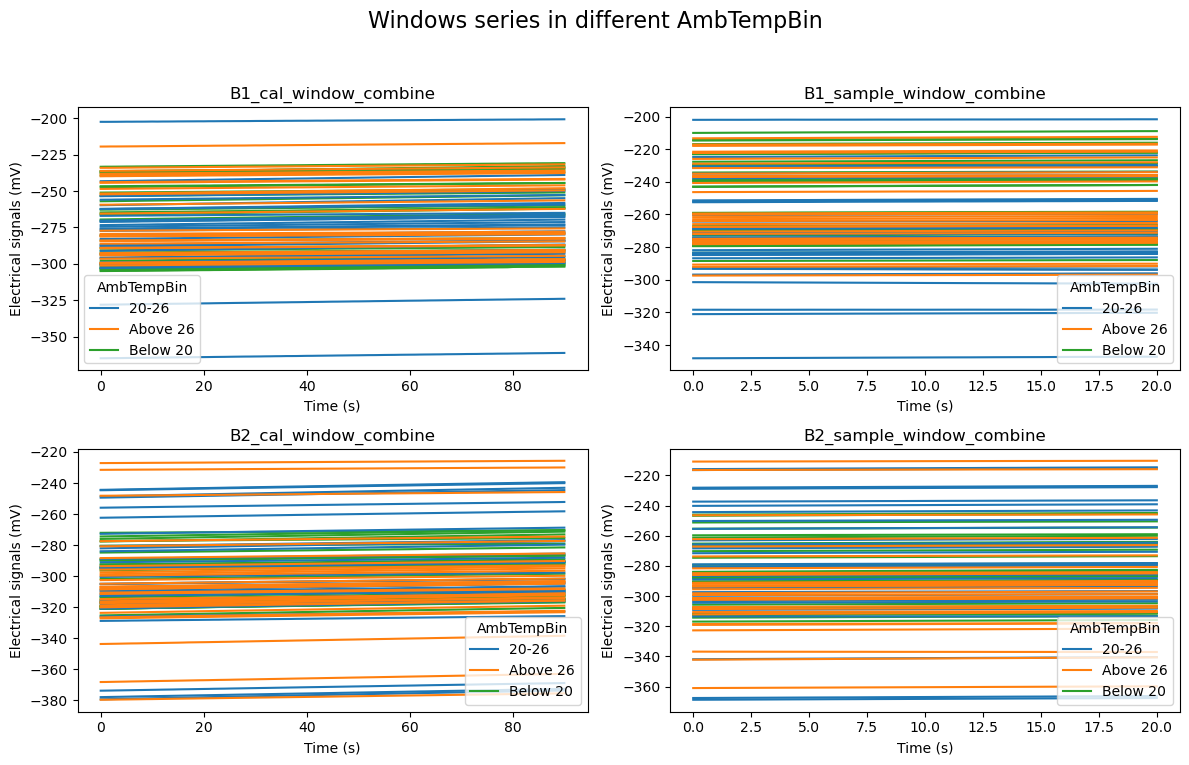

In [27]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(B1_cal_window_combine, B1_sample_window_combine, B2_cal_window_combine, B2_sample_window_combine, "AmbTempBin", "B1_cal_window_combine", "B1_sample_window_combine", "B2_cal_window_combine", "B2_sample_window_combine")


### 7.2.2 Card Age

#### System 1 and System 2: Sensor A - Cal and Sample Windows

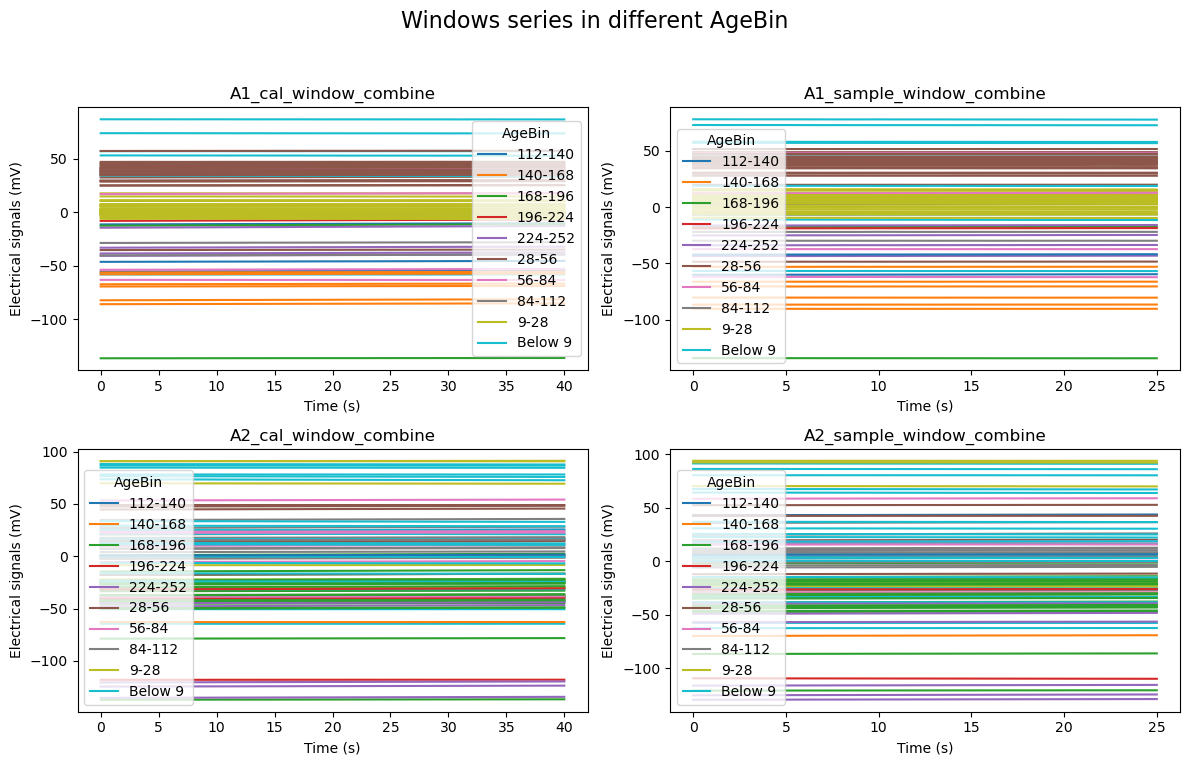

In [28]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(A1_cal_window_combine, A1_sample_window_combine,A2_cal_window_combine, A2_sample_window_combine,"AgeBin","A1_cal_window_combine", "A1_sample_window_combine","A2_cal_window_combine", "A2_sample_window_combine")

#### System 1 and System 2: Sensor B - Cal and Sample Windows

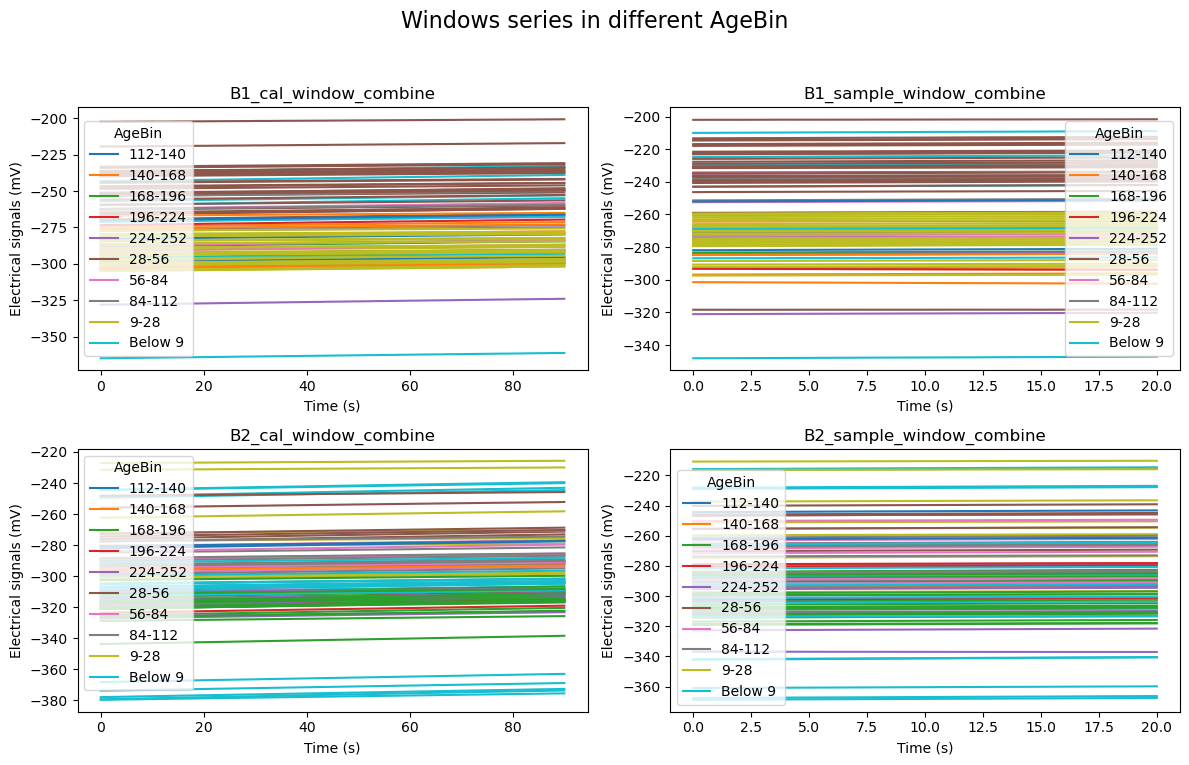

In [29]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(B1_cal_window_combine, B1_sample_window_combine, B2_cal_window_combine, B2_sample_window_combine, "AgeBin", "B1_cal_window_combine", "B1_sample_window_combine", "B2_cal_window_combine", "B2_sample_window_combine")

### 7.2.3 Fluid Type

#### System 1 and System 2: Sensor A - Cal and Sample Windows

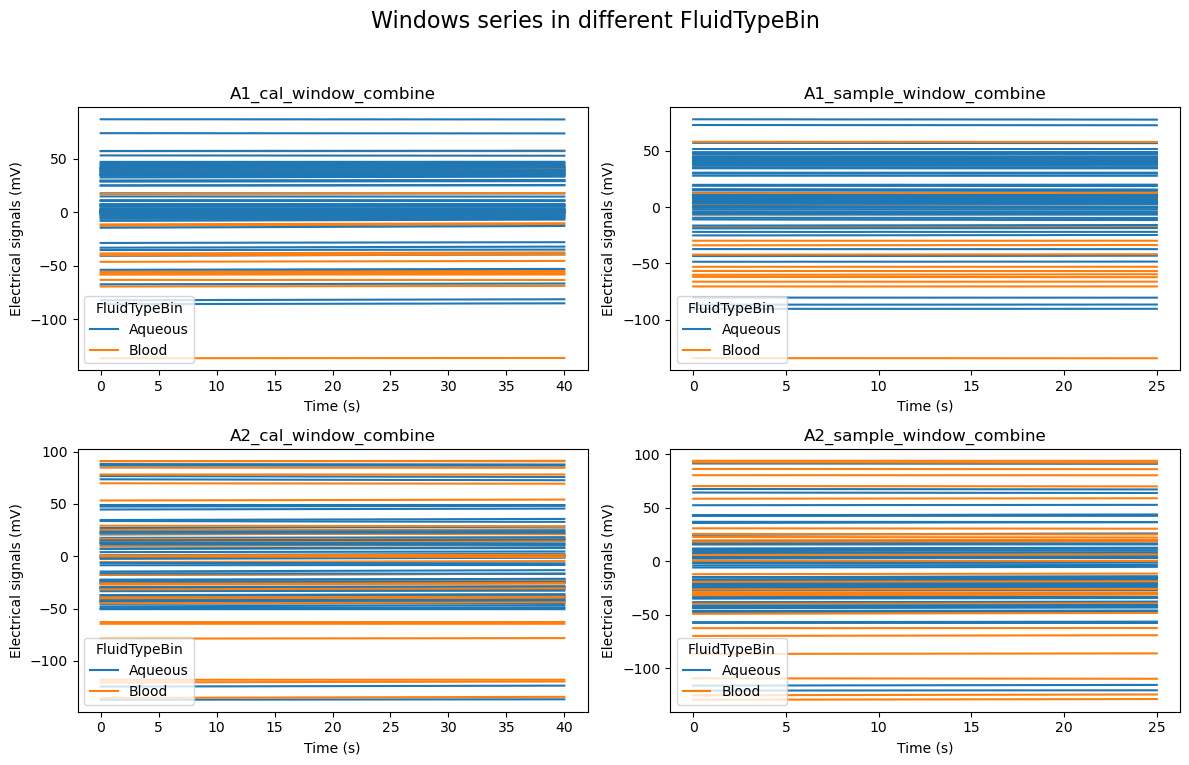

In [30]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(A1_cal_window_combine, A1_sample_window_combine,A2_cal_window_combine, A2_sample_window_combine,"FluidTypeBin","A1_cal_window_combine", "A1_sample_window_combine","A2_cal_window_combine", "A2_sample_window_combine")


#### System 1 and System 2: Sensor B - Cal and Sample Windows

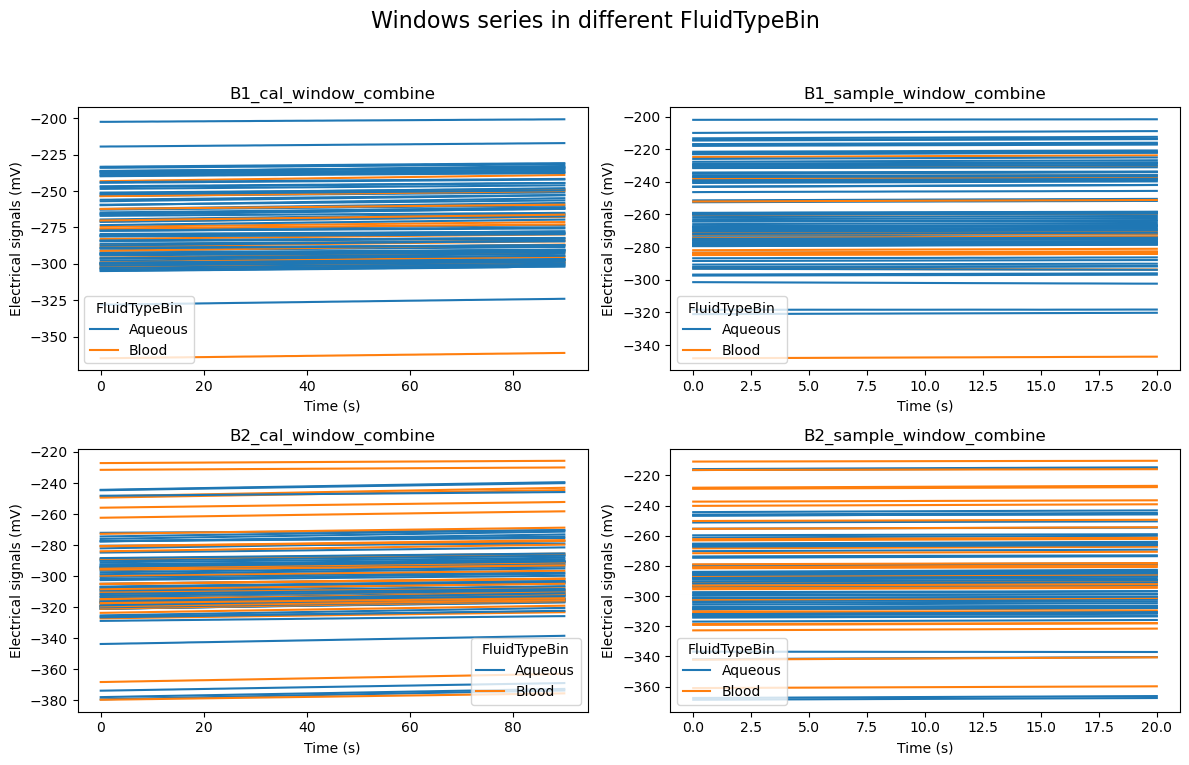

In [31]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(B1_cal_window_combine, B1_sample_window_combine, B2_cal_window_combine, B2_sample_window_combine, "FluidTypeBin", "B1_cal_window_combine", "B1_sample_window_combine", "B2_cal_window_combine", "B2_sample_window_combine")


## 7.3 Visualization of the data centered

#### System 1 and System 2: Sensor A - Cal and Sample Windows

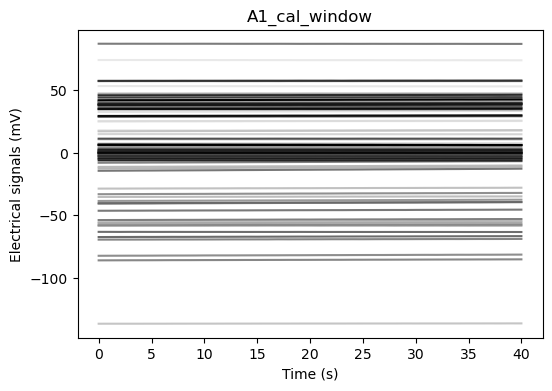

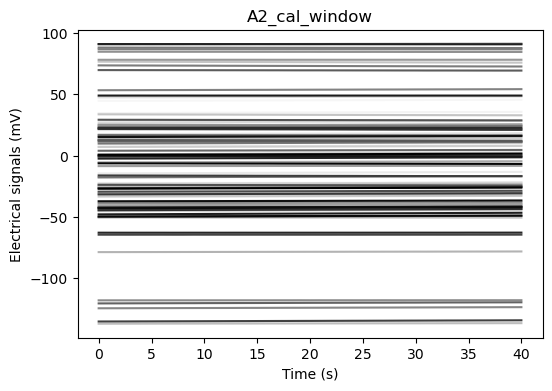

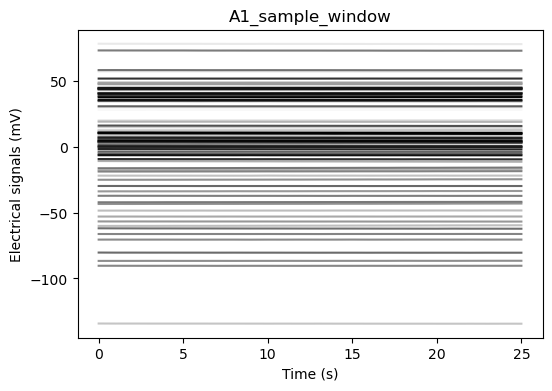

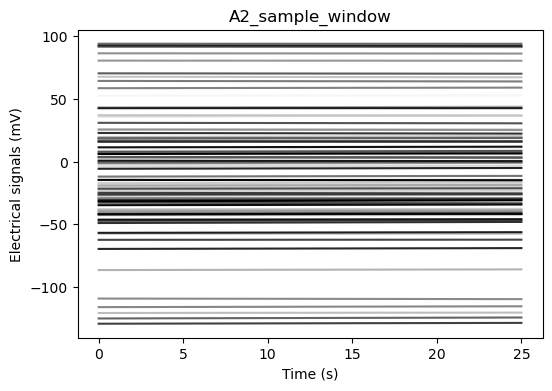

In [32]:
# Plot all the time series centered from the window extraction
plot_all_time_series(A1_cal_window, "A1_cal_window")
plot_all_time_series(A2_cal_window, "A2_cal_window")
plot_all_time_series(A1_sample_window, "A1_sample_window")
plot_all_time_series(A2_sample_window, "A2_sample_window")

### System 1 and System 2: Sensor B - Cal and Sample Windows

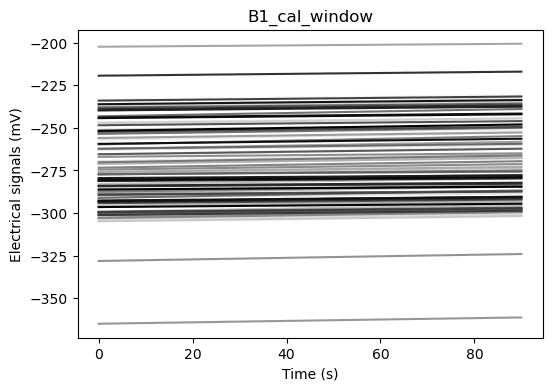

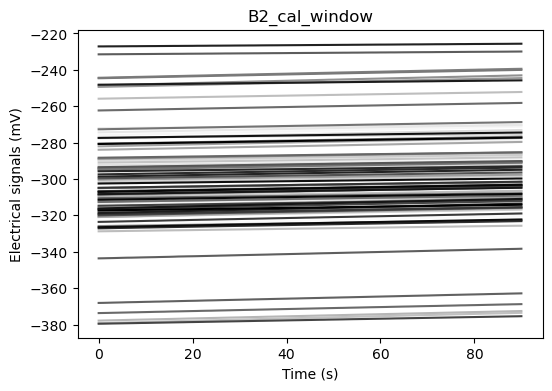

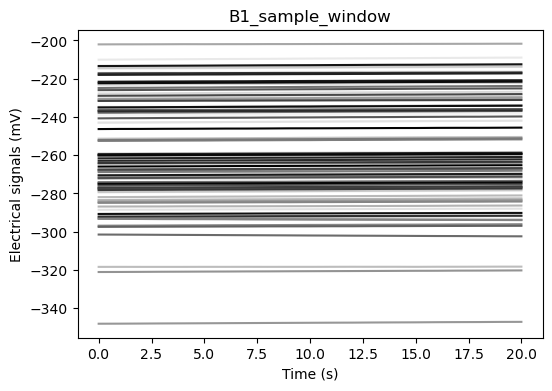

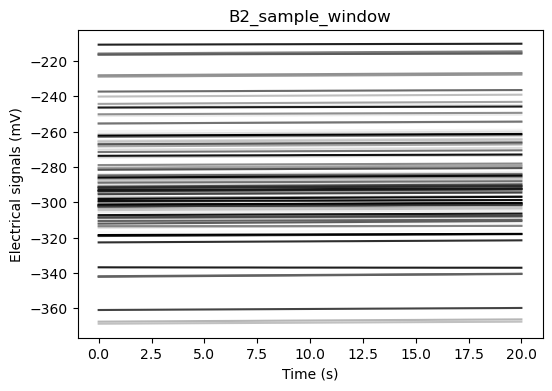

In [33]:
# Plot all the time series centered from the window extraction
plot_all_time_series(B1_cal_window, "B1_cal_window")
plot_all_time_series(B2_cal_window, "B2_cal_window")
plot_all_time_series(B1_sample_window, "B1_sample_window")
plot_all_time_series(B2_sample_window, "B2_sample_window")

# 8. Functional Principal Components

In [34]:
def perform_functional_pca(data_matrix, y_axis_min=None, y_axis_max=None, color_fpc1=None, color_fpc2=None):
    """
    Performs Functional Principal Component Analysis (FPCA) on a given data matrix and plots the results.

    Parameters:
    data_matrix (pd.DataFrame): A pandas DataFrame where each row represents a time series and each column represents a time point.
    y_axis_min (float, optional): The minimum value for the y-axis in the plots. Defaults to None.
    y_axis_max (float, optional): The maximum value for the y-axis in the plots. Defaults to None.
    color_fpc1 (str, optional): The color for the first functional principal component plot. Defaults to None.
    color_fpc2 (str, optional): The color for the second functional principal component plot. Defaults to None.

    Returns:
    None

    Prints:
    - The explained variance ratio of the first and second functional principal components.
    - The functional principal component scores for each time series.
    - The index and TestID of the time series contributing most to the first and second principal components.

    Plots:
    - The first and second functional principal components.
    - The individual plots of the first and second functional principal components.
    """
    fd = FDataGrid(data_matrix=data_matrix, grid_points=data_matrix.columns.astype(float))

    # Apply Functional PCA
    fpca = FPCA(n_components=2, centering=True)
    fpca.fit(fd)
    pc_scores = fpca.transform(fd)

    # Explain variance ratio
    print('Explain variance FPC1 (%): ', fpca.explained_variance_ratio_[0] * 100)
    print('Explain variance FPC2 (%): ', fpca.explained_variance_ratio_[1] * 100)

    # --- Loadings ---
    # Extract the principal components (loadings)
    principal_components = fpca.components_

    # Extract loadings for each time point from the first and second principal components
    loadings_pc1 = principal_components.data_matrix[0, :, 0]  # Loadings for the first PC
    loadings_pc2 = principal_components.data_matrix[1, :, 0]  # Loadings for the second PC
    loadings_df = pd.DataFrame({
    'PC1_Loadings': loadings_pc1,
    'PC2_Loadings': loadings_pc2}, index=[f'TimePoint_{i}' for i in range(data_matrix.shape[1])])
    #print("\nLoadings:\n", loadings_df)

    # --- Scores ---
    # Print the scores to see contributions of each time series to each principal component
    pc_scores_df = pd.DataFrame(pc_scores, columns=['PC1_Scores', 'PC2_Scores'],
                                index=[data_matrix.index[i] for i in range(data_matrix.shape[0])])
    print("FPC Scores:\n", pc_scores_df)

    # Identify which time series (functional data object) contributes the most to each principal component
    max_contribution_index_pc1 = np.argmax(np.abs(pc_scores[:, 0]))  # Index of the maximum absolute score in the first PC
    max_contribution_index_pc2 = np.argmax(np.abs(pc_scores[:, 1]))  # Index of the maximum absolute score in the second PC

    print(f'The time series contributing most to PC1 is at index {max_contribution_index_pc1} with TestID {data_matrix.index[max_contribution_index_pc1]}')
    print(f'The time series contributing most to PC2 is at index {max_contribution_index_pc2} with TestID {data_matrix.index[max_contribution_index_pc2]}')

    # --- Plotting Principal Components ---
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))

    # Both Functional PC's
    axs[0].plot(fpca.components_[0].grid_points[0], fpca.components_[0].data_matrix[0].flatten(), linestyle='-', label='Component 1', color = color_fpc1)
    axs[0].plot(fpca.components_[1].grid_points[0], fpca.components_[1].data_matrix[0].flatten(), linestyle='-', label='Component 2', color = color_fpc2)
    axs[0].set_title("Functional Principal Components")
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Functional PC Values')
    axs[0].legend()
    axs[0].grid(False)
    axs[0].set_ylim(y_axis_min, y_axis_max)

    # FPC1
    axs[1].plot(fpca.components_[0].grid_points[0], fpca.components_[0].data_matrix[0].flatten(), linestyle='-', label='Component 1', color = color_fpc1)
    axs[1].set_title("Functional Component 1")
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('')
    axs[1].legend()
    axs[1].grid(False)
    axs[1].set_ylim(y_axis_min, y_axis_max)

    # FPC2
    axs[2].plot(fpca.components_[1].grid_points[0], fpca.components_[1].data_matrix[0].flatten(), linestyle='-', label='Component 2', color = color_fpc2)
    axs[2].set_title("Functional Component 2")
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('')
    axs[2].legend()
    axs[2].grid(False)
    axs[2].set_ylim(y_axis_min, y_axis_max)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()
    return fpca

In [35]:
# Note: For the following plots we can adjust the y-axis limit with the parameters y_axis_min and y_axis_max from the function perform_functional_pca().
# If these parameters are not provided then the plots will display the default range, however, we should be aware of this.
# For instance: perform_functional_pca(A1_blood_cal_window, y_axis_min=-0.6, y_axis_max=0.6)

----------------------------------------- Sensor A -----------------------------------------------

## Cal Window

### Cal Window: System 1/2

In [36]:
# Running on center data is different than running on raw data
#perform_functional_pca(center_data(A1_blood_cal_window), color_fpc1='tab:blue', color_fpc2='tab:cyan')

Explain variance FPC1 (%):  99.99872931514243
Explain variance FPC2 (%):  0.0012646089605268577
FPC Scores:
           PC1_Scores  PC2_Scores
12515599    4.576746   -0.567529
12514414 -206.473881    0.338864
12515536   26.877104   -0.690842
12514485  -31.775631   -0.644894
12514261   27.708973   -0.849372
...              ...         ...
12514358 -183.521295    0.024154
12515781   -1.494102   -1.209351
12514408   38.149872   -0.739431
12516002 -229.019518    0.948829
12514252   -1.143212   -0.852695

[99 rows x 2 columns]
The time series contributing most to PC1 is at index 33 with TestID 12597823
The time series contributing most to PC2 is at index 60 with TestID 12600213


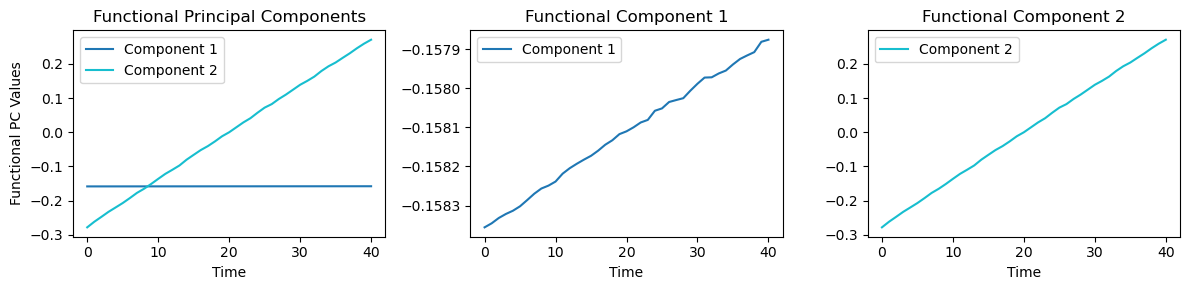

Explain variance FPC1 (%):  99.99855269789094
Explain variance FPC2 (%):  0.0014454948419269276
FPC Scores:
          PC1_Scores  PC2_Scores
3561397 -157.145617   -1.204573
3561370  140.739577   -0.984811
3561433  189.432975   -0.446246
3561333  190.723329   -0.869398
3561435   83.719632   -0.901868
...             ...         ...
3561613  212.847370   -0.178055
3561567  255.685964    0.006545
3553776  -14.487296    1.841662
3559003  -62.949337   -0.712993
3552988  111.956227   -0.541956

[99 rows x 2 columns]
The time series contributing most to PC1 is at index 37 with TestID 3551751
The time series contributing most to PC2 is at index 74 with TestID 3553771


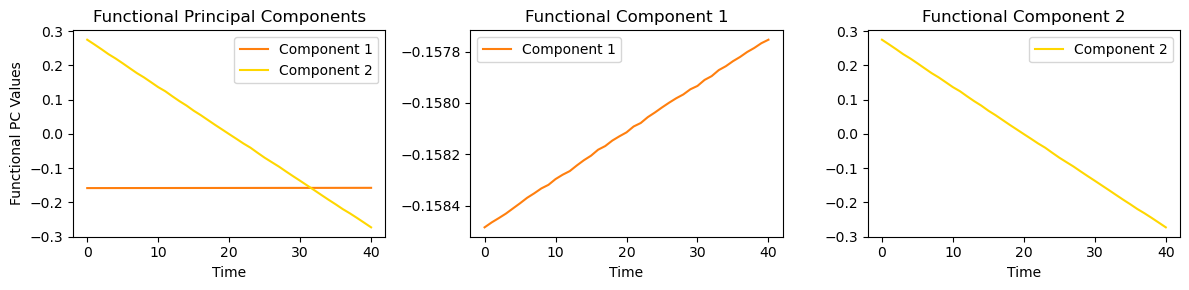

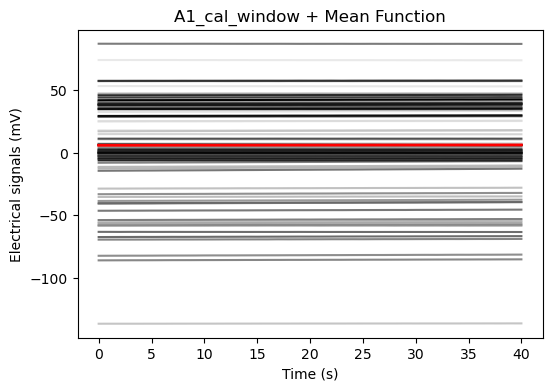

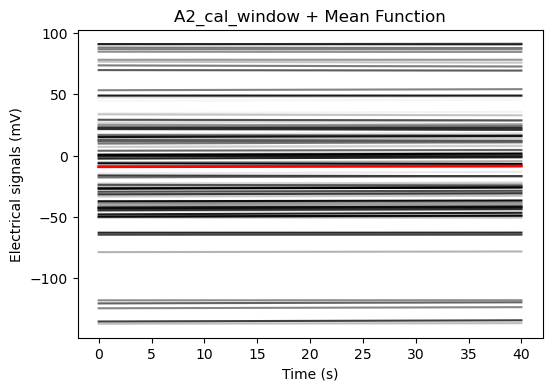

In [37]:
fpca_A1_cal_window = perform_functional_pca(A1_cal_window, color_fpc1='tab:blue', color_fpc2='tab:cyan')
fpca_A2_cal_window = perform_functional_pca(A2_cal_window, color_fpc1='tab:orange', color_fpc2='gold')
x_A1_cal_window = fpca_A1_cal_window.components_.grid_points
y_A1_cal_window = fpca_A1_cal_window.mean_.data_matrix
x_A2_cal_window = fpca_A2_cal_window.components_.grid_points
y_A2_cal_window = fpca_A2_cal_window.mean_.data_matrix

plot_all_time_series_and_mean_fpca(A1_cal_window, 'A1_cal_window + Mean Function', x_A1_cal_window[0], y_A1_cal_window.flatten())
plot_all_time_series_and_mean_fpca(A2_cal_window, 'A2_cal_window + Mean Function', x_A2_cal_window[0], y_A2_cal_window.flatten())

## Sample Window

### Sample Window: System 1/2

Explain variance FPC1 (%):  99.9996316673738
Explain variance FPC2 (%):  0.00036245837171424567
FPC Scores:
           PC1_Scores  PC2_Scores
12515599  -11.893412   -0.282941
12514414 -182.450248   -0.019689
12515536    5.229992   -0.454924
12514485  -39.404291   -0.286938
12514261    7.187026   -0.417072
...              ...         ...
12514358 -164.079656    0.001524
12515781  -13.084455   -0.577394
12514408   14.546449   -0.325191
12516002 -151.070565    0.383329
12514252  -16.701259   -0.353561

[99 rows x 2 columns]
The time series contributing most to PC1 is at index 33 with TestID 12597823
The time series contributing most to PC2 is at index 39 with TestID 12557542


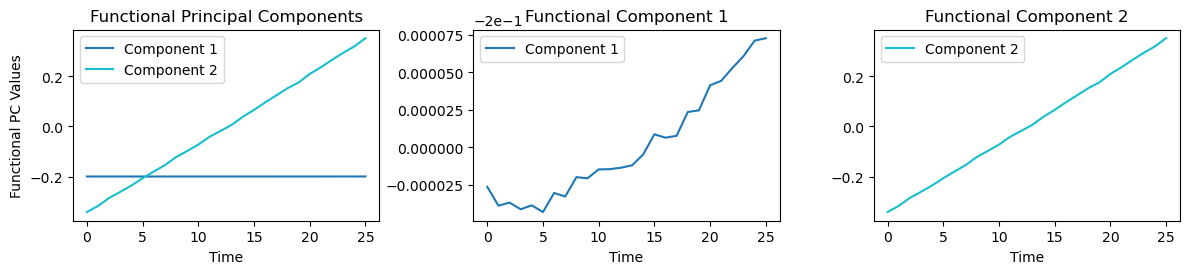

Explain variance FPC1 (%):  99.99938075467273
Explain variance FPC2 (%):  0.0006165908349655789
FPC Scores:
          PC1_Scores  PC2_Scores
3561397 -100.365214   -0.674850
3561370   74.000436   -0.494442
3561433  178.289159   -0.419304
3561333  113.147161   -0.528611
3561435   93.525122   -0.743636
...             ...         ...
3561613  134.133614   -0.204023
3561567  170.539715   -0.114824
3553776   35.319771    0.900360
3559003  -69.852742   -0.367726
3552988  117.881476   -0.555109

[99 rows x 2 columns]
The time series contributing most to PC1 is at index 78 with TestID 3552739
The time series contributing most to PC2 is at index 53 with TestID 3563515


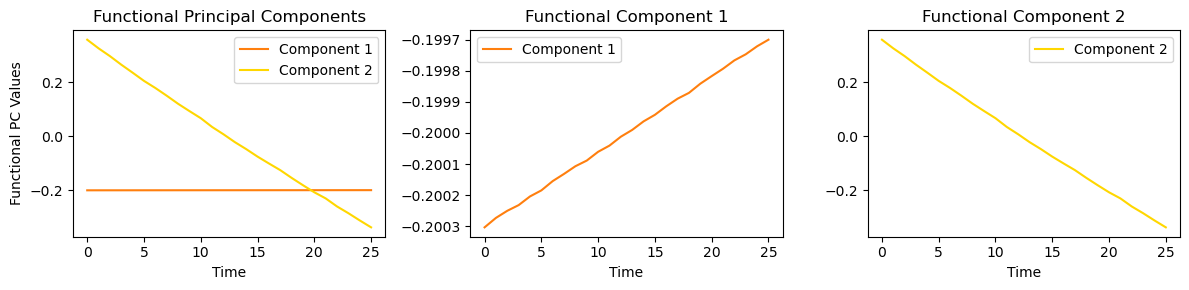

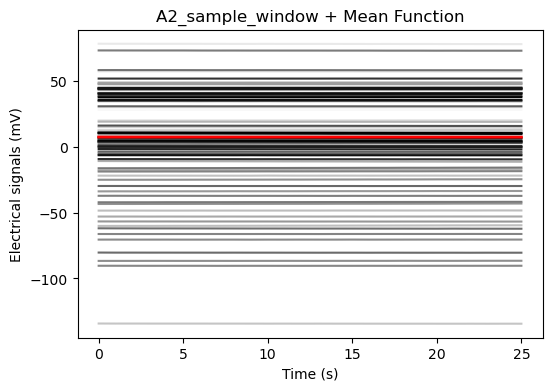

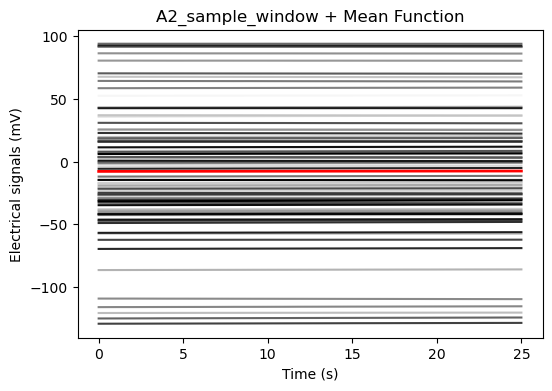

In [38]:
fpca_A1_sample_window = perform_functional_pca(A1_sample_window, color_fpc1='tab:blue', color_fpc2='tab:cyan')
fpca_A2_sample_window = perform_functional_pca(A2_sample_window, color_fpc1='tab:orange', color_fpc2='gold')
x_A1_sample_window = fpca_A1_sample_window.components_.grid_points
y_A1_sample_window = fpca_A1_sample_window.mean_.data_matrix
x_A2_sample_window = fpca_A2_sample_window.components_.grid_points
y_A2_sample_window = fpca_A2_sample_window.mean_.data_matrix

plot_all_time_series_and_mean_fpca(A1_sample_window, 'A2_sample_window + Mean Function', x_A1_sample_window[0], y_A1_sample_window.flatten())
plot_all_time_series_and_mean_fpca(A2_sample_window, 'A2_sample_window + Mean Function', x_A2_sample_window[0], y_A2_sample_window.flatten())

------------------------------------- Sensor B ------------------------------------------------

## Cal Window

### Cal Window:  System 1/2

Explain variance FPC1 (%):  99.99192958321098
Explain variance FPC2 (%):  0.008043805766316303
FPC Scores:
           PC1_Scores  PC2_Scores
12515599  212.878555    1.063159
12514414 -101.131489    0.432219
12515536  269.361833   -0.093282
12514485  232.123788    0.687849
12514261  165.774495   -2.483119
...              ...         ...
12514358 -290.814875   -1.438083
12515781   55.768854   -3.443576
12514408  205.484879   -2.300084
12516002 -227.406319    2.503559
12514252  109.162218   -3.335691

[99 rows x 2 columns]
The time series contributing most to PC1 is at index 49 with TestID 12544834
The time series contributing most to PC2 is at index 58 with TestID 12446960


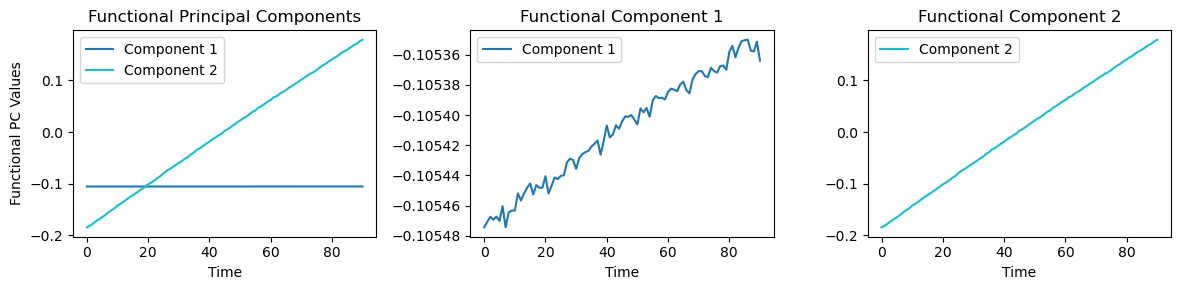

Explain variance FPC1 (%):  99.9914560974017
Explain variance FPC2 (%):  0.008515998196527685
FPC Scores:
          PC1_Scores  PC2_Scores
3561397 -169.093745   -0.784933
3561370  128.073613    1.129585
3561433  153.224614    0.764806
3561333  166.941743    2.174104
3561435  206.983911    1.778075
...             ...         ...
3561613  221.737720    0.132618
3561567   83.802174   -2.159181
3553776   39.330346   -0.050612
3559003 -208.339426   -0.062317
3552988  140.015926   -2.568822

[99 rows x 2 columns]
The time series contributing most to PC1 is at index 77 with TestID 3559957
The time series contributing most to PC2 is at index 51 with TestID 3545133


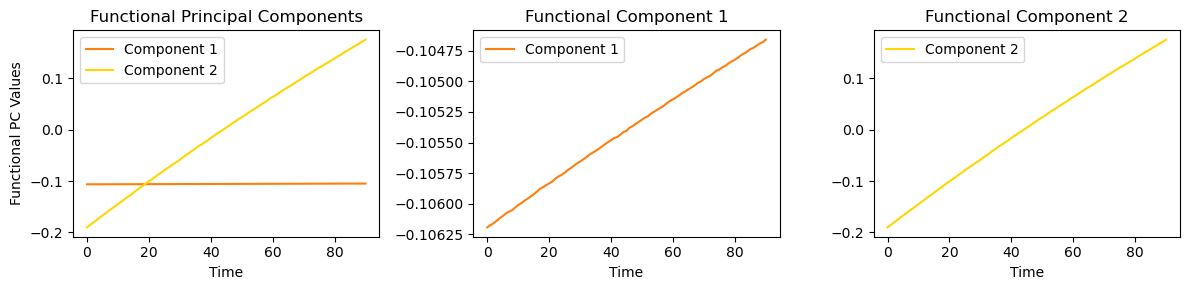

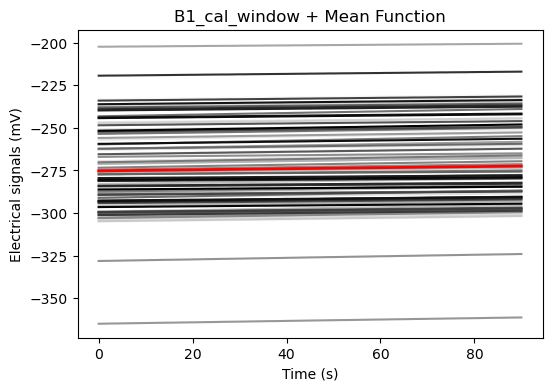

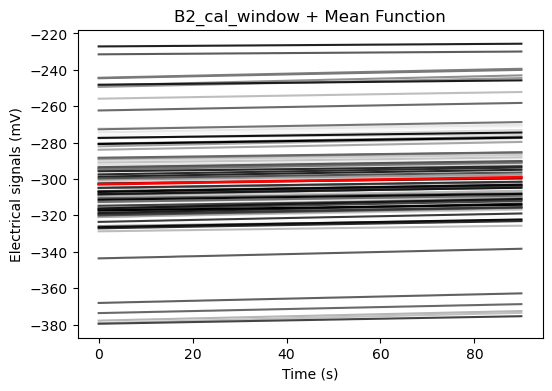

In [39]:
fpca_B1_cal_window = perform_functional_pca(B1_cal_window, color_fpc1='tab:blue', color_fpc2='tab:cyan')
fpca_B2_cal_window = perform_functional_pca(B2_cal_window, color_fpc1='tab:orange', color_fpc2='gold')
x_B1_cal_window = fpca_B1_cal_window.components_.grid_points
y_B1_cal_window = fpca_B1_cal_window.mean_.data_matrix
x_B2_cal_window = fpca_B2_cal_window.components_.grid_points
y_B2_cal_window = fpca_B2_cal_window.mean_.data_matrix

plot_all_time_series_and_mean_fpca(B1_cal_window, 'B1_cal_window + Mean Function', x_B1_cal_window[0], y_B1_cal_window.flatten())
plot_all_time_series_and_mean_fpca(B2_cal_window, 'B2_cal_window + Mean Function', x_B2_cal_window[0], y_B2_cal_window.flatten())

## Sample window

### Sample Window:  System 1/2

Explain variance FPC1 (%):  99.99894561603622
Explain variance FPC2 (%):  0.0010426461215874497
FPC Scores:
           PC1_Scores  PC2_Scores
12515599   58.944978   -0.282874
12514414  -88.989352   -0.133386
12515536   86.726201   -0.336858
12514485   70.637369   -0.345174
12514261   43.731273   -0.108814
...              ...         ...
12514358 -167.167497    0.095144
12515781    1.733060    0.087992
12514408   68.275477   -0.063462
12516002  -59.804071    0.097181
12514252   27.993405    0.004933

[99 rows x 2 columns]
The time series contributing most to PC1 is at index 49 with TestID 12544834
The time series contributing most to PC2 is at index 64 with TestID 12538697


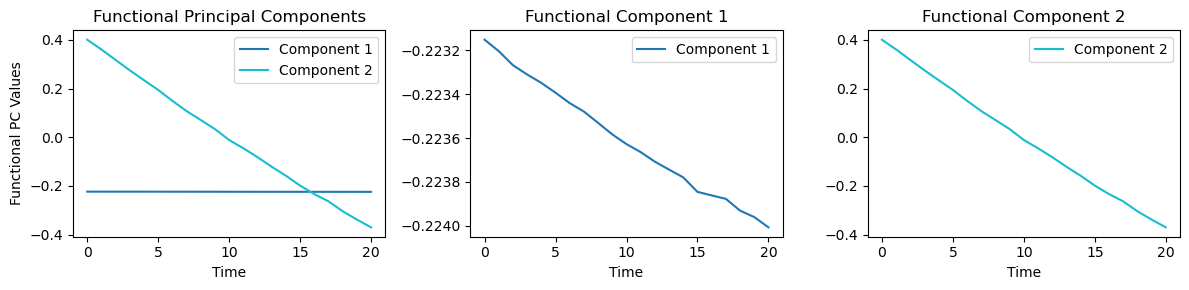

Explain variance FPC1 (%):  99.99938675502452
Explain variance FPC2 (%):  0.0006100171359961243
FPC Scores:
          PC1_Scores  PC2_Scores
3561397  -32.779656   -0.027155
3561370    1.035873   -0.340186
3561433  114.319481   -0.040878
3561333   18.112820   -0.396914
3561435  135.246922   -0.097670
...             ...         ...
3561613   51.024463   -0.270776
3561567   -2.947980   -0.058211
3553776   65.972382    0.100089
3559003 -108.714697    0.087192
3552988  143.497293    0.440366

[99 rows x 2 columns]
The time series contributing most to PC1 is at index 35 with TestID 3565875
The time series contributing most to PC2 is at index 88 with TestID 3563649


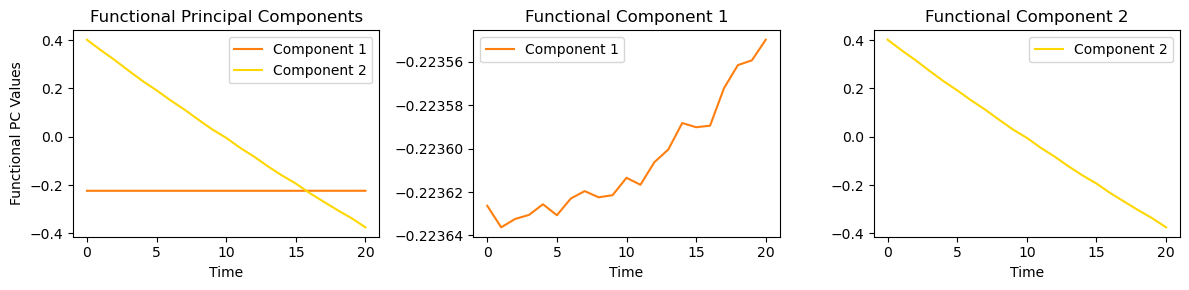

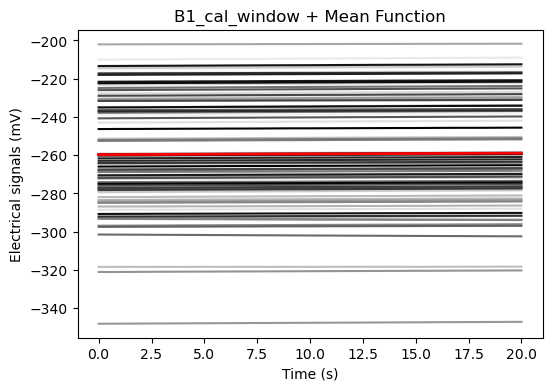

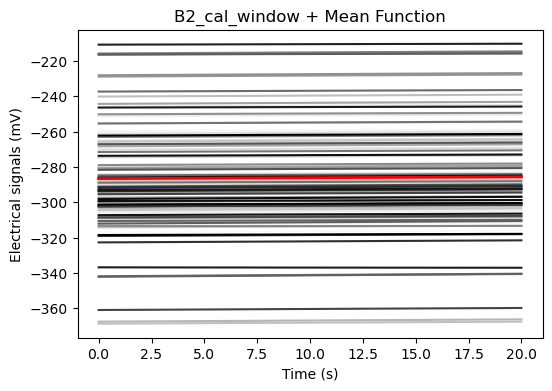

In [40]:
fpca_B1_sample_window = perform_functional_pca(B1_sample_window, color_fpc1='tab:blue', color_fpc2='tab:cyan')
fpca_B2_sample_window = perform_functional_pca(B2_sample_window, color_fpc1='tab:orange', color_fpc2='gold')
x_B1_sample_window = fpca_B1_sample_window.components_.grid_points
y_B1_sample_window = fpca_B1_sample_window.mean_.data_matrix
x_B2_sample_window = fpca_B2_sample_window.components_.grid_points
y_B2_sample_window = fpca_B2_sample_window.mean_.data_matrix

plot_all_time_series_and_mean_fpca(B1_sample_window, 'B1_cal_window + Mean Function', x_B1_sample_window[0], y_B1_sample_window.flatten())
plot_all_time_series_and_mean_fpca(B2_sample_window, 'B2_cal_window + Mean Function', x_B2_sample_window[0], y_B2_sample_window.flatten())

# 8 FPCA

## 8.1. Functional PCA characterization function

In [41]:
def fpca_two_inputs(time_series_s1, time_series_s2, y_axis_min=None, y_axis_max=None):
    """
    Performs Functional Principal Component Analysis (FPCA) on two sets of time series data from different systems
    and plots the first principal component for both systems on the same graph.

    Parameters:
    time_series_s1 (pd.DataFrame): A pandas DataFrame representing time series data from System 1. Each row represents
                                   a time series and each column represents a time point.
    time_series_s2 (pd.DataFrame): A pandas DataFrame representing time series data from System 2. Each row represents
                                   a time series and each column represents a time point.
    y_axis_min (float, optional): The minimum value for the y-axis in the plot. Defaults to None.
    y_axis_max (float, optional): The maximum value for the y-axis in the plot. Defaults to None.

    Returns:
    tuple: A tuple containing two pandas DataFrames representing the functional principal component scores for System 1
           and System 2 respectively.

    Prints:
    - The explained variance ratio of the first principal component for both systems.
    - The functional principal component scores for each time series in both systems.
    - Plots the first principal component for both systems on the same graph.

    """
    # Convert the data matrix to an FDataGrid object
    fd_s1 = FDataGrid(data_matrix=time_series_s1, grid_points=time_series_s1.columns.astype(float)) # System 1
    fd_s2 = FDataGrid(data_matrix=time_series_s2, grid_points=time_series_s2.columns.astype(float)) # System 2

    # Apply Functional PCA for System 1
    fpca_s1 = FPCA(n_components=2, centering=True)
    fpca_s1.fit(fd_s1)
    fpc_and_scores_s1 = fpca_s1.transform(fd_s1)

    # Apply Functional PCA for System 2
    fpca_s2 = FPCA(n_components=2)
    fpca_s2.fit(fd_s2)
    fpc_and_scores_s2 = fpca_s2.transform(fd_s2)

    # --- Explain variance ratio ---
    # System 1
    print('S1 Explain variance PC1 (%): ', fpca_s1.explained_variance_ratio_[0] * 100)
    #print('S1 Explain variance PC2 (%): ', fpca_s1.explained_variance_ratio_[1] * 100)
    # System 2
    print('S2 Explain variance PC1 (%): ', fpca_s2.explained_variance_ratio_[0] * 100)
    #print('S2 Explain variance PC2 (%): ', fpca_s2.explained_variance_ratio_[1] * 100)

    # --- Loadings ---
    # Extract the principal components (loadings)
    principal_components_s1 = fpca_s1.components_ # System 1
    principal_components_s2 = fpca_s2.components_ # System 2

    # --- Scores ---
    # Print the scores to see contributions of each time series to each principal component

    # System 1
    pc_scores_s1 = pd.DataFrame(fpc_and_scores_s1, columns=['PC1_Scores', 'PC2_Scores'],
                                index=[time_series_s1.index[i] for i in range(time_series_s1.shape[0])])
    # System 2
    pc_scores_s2 = pd.DataFrame(fpc_and_scores_s2, columns=['PC1_Scores', 'PC2_Scores'],
                                index=[time_series_s2.index[i] for i in range(time_series_s2.shape[0])])

    # --- Plotting First Principal Component for both Systems ---
    # Extracting data for System 1
    x1 = fpca_s1.components_[0].grid_points[0]
    y1 = fpca_s1.components_[0].data_matrix[0].flatten()

    # Extracting data for System 2
    x2 = fpca_s2.components_[0].grid_points[0]
    y2 = fpca_s2.components_[0].data_matrix[0].flatten()

    # Plotting both curves in the same graph
    fig = plt.figure(figsize=(5, 3))
    plt.plot(x1, y1, linestyle='-', label='Component 1 - S1')
    plt.plot(x2, y2, linestyle='-', label='Component 1 - S2')

    plt.legend()
    plt.grid(False)
    plt.xlabel('Time')
    plt.ylabel('Functional PC 1 Values')
    plt.title('System 1 versus System 2')
    plt.ylim(y_axis_min, y_axis_max)
    plt.show()

    return pc_scores_s1, pc_scores_s2,fpca_s1.components_[0],fpca_s2.components_[0]

In [42]:
def create_pc_scores_plots(pc_scores_s1, pc_scores_s2, features_s1, features_s2):
    """
    Creates scatterplots for the functional principal component scores mapping with colors the additional features for every TestID for two systems.

    Parameters:
    pc_scores_s1 (pd.DataFrame): A pandas DataFrame representing the functional principal component scores for System 1.
    pc_scores_s2 (pd.DataFrame): A pandas DataFrame representing the functional principal component scores for System 2.
    features_s1 (pd.DataFrame): A pandas DataFrame representing additional features for System 1.
    features_s2 (pd.DataFrame): A pandas DataFrame representing additional features for System 2.

    Returns:
    scatterplots: A concatenated chart containing scatterplots of the functional principal component scores combined with additional features for both systems.
    """
    # --- Scores combined with Additional Features ---
    # Reset the index, making the index a column in the DataFrame
    pc_scores_s1_reset = pc_scores_s1.reset_index()
    pc_scores_s2_reset = pc_scores_s2.reset_index()
    pc_scores_s1_reset.rename(columns={'index': 'TestID'}, inplace=True)
    pc_scores_s2_reset.rename(columns={'index': 'TestID'}, inplace=True)

    # Merging functional pc scores and additional features by TestID
    system1_scores_merged = pd.merge(pc_scores_s1_reset, features_s1, how='inner', on=['TestID'])
    system2_scores_merged = pd.merge(pc_scores_s2_reset, features_s2, how='inner', on=['TestID'])

    # --- Characterization of the Functional PC Scores ---

    # Select Features
    selected_columns = ['TestID', 'PC1_Scores','PC2_Scores','FluidType','AgeOfCardInDaysAtTimeOfTest', 'AmbientTemperature', 'Fluid_Temperature_Filled']
    data_s1 = system1_scores_merged[selected_columns].copy()
    data_s2 = system2_scores_merged[selected_columns].copy()

    # Binning continuous predictors into discrete intervals
    data_s1.loc[:, 'AmbientTempBin'] = pd.cut(data_s1['AmbientTemperature'],  bins=[-1, 20, 26, 100], labels=['Below 20', '20-26', 'Above 26'])
    data_s2.loc[:, 'AmbientTempBin'] = pd.cut(data_s2['AmbientTemperature'],  bins=[-1, 20, 26, 100], labels=['Below 20', '20-26', 'Above 26'])
    data_s1.loc[:, 'FluidTempBin'] = pd.cut(data_s1['Fluid_Temperature_Filled'],  bins=[-1, 20, 26, 100], labels=['Below 20', '20-26', 'Above 26'])
    data_s2.loc[:, 'FluidTempBin'] = pd.cut(data_s2['Fluid_Temperature_Filled'],  bins=[-1, 20, 26, 100], labels=['Below 20', '20-26', 'Above 26'])
    
    data_s1.loc[:, 'FluidType'] = np.where(data_s2['FluidType'].str.startswith('Eurotrol'), 'Aqueous', 'Blood')
    data_s2.loc[:, 'FluidType'] = np.where(data_s2['FluidType'].str.startswith('Eurotrol'), 'Aqueous', 'Blood')
    # CardAge by bins of 28 days
    # Determine the max age to set the range for bins
    max_age = data_s2['AgeOfCardInDaysAtTimeOfTest'].max()+1

    # Define the custom bins without duplicates
    bins_age = [0, 10, 28] + list(np.arange(56, max_age + 28, 28))

    # Create labels for the bins
    labels_age = ['[0-9]', '(9-28]'] + [f'({i}-{i+28}]' for i in np.arange(28, max_age, 28)]

    # Assign bins to the AgeBin column
    data_s1.loc[:, 'AgeBin'] = pd.cut(data_s1['AgeOfCardInDaysAtTimeOfTest'], bins=bins_age, labels=labels_age)
    data_s2.loc[:, 'AgeBin'] = pd.cut(data_s2['AgeOfCardInDaysAtTimeOfTest'], bins=bins_age, labels=labels_age)

    # --- Define a color map for fluid types ---
    color_map_temp = {
        'Below 20': '#4e79a7',
        '20-26': '#f28e2b',
        'Above 26': '#e16759',
    }

    # Combine data to get the overall min and max for both axes
    combined_data = pd.concat([data_s1, data_s2])

    # Determine the range for x and y axes
    min_x = combined_data['PC1_Scores'].min()
    max_x = combined_data['PC1_Scores'].max()
    min_y = combined_data['PC2_Scores'].min()
    max_y = combined_data['PC2_Scores'].max()

    # --- Visualizations ---
    # System 1
    scatter_age_s1 = alt.Chart(data_s1).mark_circle().encode(
    alt.X('PC1_Scores', title="FPC Score 1", scale=alt.Scale(domain=[min_x, max_x])),
    alt.Y('PC2_Scores', title="FPC Score 2", scale=alt.Scale(domain=[min_y, max_y])),
    color=alt.Color('AgeBin', scale=alt.Scale(scheme='tableau10'), title="Days"),
    tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('AgeOfCardInDaysAtTimeOfTest', title="Card Age")]
    ).properties(
        title='Card Age',
        width=580,
        height=280
   )


    scatter_temp_s1 = alt.Chart(data_s1).mark_circle().encode(
        alt.X('PC1_Scores', title="FPC Score 1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="FPC Score 2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('AmbientTempBin', scale=alt.Scale(domain=list(color_map_temp.keys()), range=list(color_map_temp.values())), title="°C"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('AmbientTemperature', title="Ambient Temperature")]
    ).properties(
        title='Ambient Temperature',
        width=580,
        height=280
    )


    scatter_fluid_s1 = alt.Chart(data_s1).mark_circle().encode(
        alt.X('PC1_Scores', title="FPC Score 1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="FPC Score 2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('FluidType', scale=alt.Scale(scheme='tableau10'), title="Fluid"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('FluidType', title="Fluid Type")]
    ).properties(
        title='Fluid Type',
        width=580,
        height=280
    )

    scatter_fluidTemp_s1 = alt.Chart(data_s1).mark_circle().encode(
        alt.X('PC1_Scores', title="FPC Score 1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="FPC Score 2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('FluidTempBin', scale=alt.Scale(domain=list(color_map_temp.keys()), range=list(color_map_temp.values())), title="°C"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('Fluid_Temperature_Filled', title="Fluid Temperature")]
    ).properties(
        title='Fluid Temperature',
        width=580,
        height=280
    )

    # System 2
    scatter_age_s2 = alt.Chart(data_s2).mark_circle().encode(
        alt.X('PC1_Scores', title="FPC Score 1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="FPC Score 2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('AgeBin', scale=alt.Scale(scheme='tableau10'), title="Days"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('AgeOfCardInDaysAtTimeOfTest', title="Card Age")]
    ).properties(
        title='Card Age',
        width=580,
        height=280
    )

    scatter_temp_s2 = alt.Chart(data_s2).mark_circle().encode(
        alt.X('PC1_Scores', title="FPC Score 1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="FPC Score 2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('AmbientTempBin', scale=alt.Scale(domain=list(color_map_temp.keys()), range=list(color_map_temp.values())), title="°C"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('AmbientTemperature', title="Ambient Temperature")]
    ).properties(
        title='Ambient Temperature',
        width=580,
        height=280
    )

    scatter_fluid_s2 = alt.Chart(data_s2).mark_circle().encode(
        alt.X('PC1_Scores', title="FPC Score 1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="FPC Score 2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('FluidType', scale=alt.Scale(scheme='tableau10'), title="Fluid"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('FluidType', title="Fluid Type")]
    ).properties(
        title='Fluid Type',
        width=580,
        height=280
    )

    scatter_fluidTemp_s2 = alt.Chart(data_s2).mark_circle().encode(
        alt.X('PC1_Scores', title="FPC Score 1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="FPC Score 2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('FluidTempBin', scale=alt.Scale(domain=list(color_map_temp.keys()), range=list(color_map_temp.values())), title="°C"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('Fluid_Temperature_Filled', title="Fluid Temperature")]
    ).properties(
        title='Fluid Temperature',
        width=580,
        height=280
    )


    # --- Display the plots ---
    # System 1 plots
    s1_plots = alt.hconcat(
        scatter_fluid_s1, scatter_age_s1, scatter_temp_s1, scatter_fluidTemp_s1
    ).resolve_scale(
        color='independent'
    ).properties(
        title='System 1'
    )

    # System 2 plots
    s2_plots = alt.hconcat(
        scatter_fluid_s2, scatter_age_s2, scatter_temp_s2, scatter_fluidTemp_s2
    ).resolve_scale(
        color='independent'
    ).properties(
        title='System 2'
    )

    # Concatenating plots in same grid
    plots_vconcatenated = alt.vconcat(
        s1_plots,
        s2_plots
    ).configure_view(
        stroke=None
    )

    return plots_vconcatenated

## 8.2 Functional PC1 plots (both systems) and Characterization of FPC Scores

### System 1 versus System 2: Sensor A - Cal Window

S1 Explain variance PC1 (%):  99.99872931514243
S2 Explain variance PC1 (%):  99.99855269789094


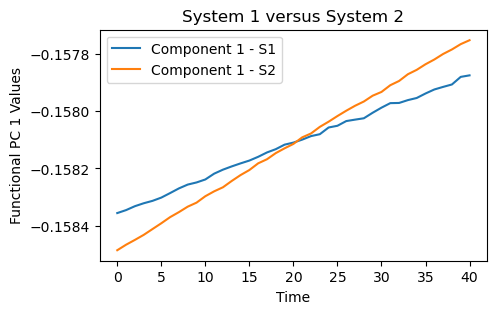

alt.VConcatChart(...)

In [43]:
pc_scores_s1_A_cal_window, pc_scores_s2_A_cal_window,fpca_s1_A_cal_window,fpca_s2_A_cal_window = fpca_two_inputs(A1_cal_window, A2_cal_window)
create_pc_scores_plots(pc_scores_s1_A_cal_window, pc_scores_s2_A_cal_window, A1_Merged, A2_Merged)

### System 1 versus System 2: Sensor A - Sample Window

S1 Explain variance PC1 (%):  99.9996316673738
S2 Explain variance PC1 (%):  99.99938075467273


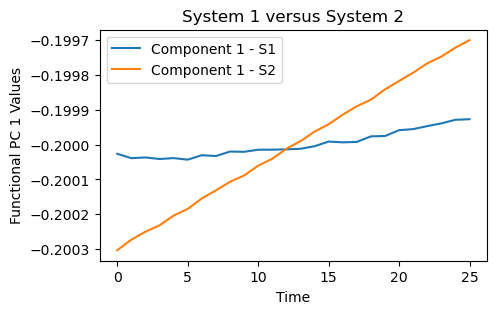

alt.VConcatChart(...)

In [44]:
pc_scores_s1_A_sample_window, pc_scores_s2_A_sample_window,fpca_s1_A_sample_window,fpca_s2_A_sample_window = fpca_two_inputs(A1_sample_window, A2_sample_window)
create_pc_scores_plots(pc_scores_s1_A_sample_window, pc_scores_s2_A_sample_window, A1_Merged, A2_Merged)

### System 1 versus System 2: Sensor B - Cal Window

S1 Explain variance PC1 (%):  99.99192958321098
S2 Explain variance PC1 (%):  99.9914560974017


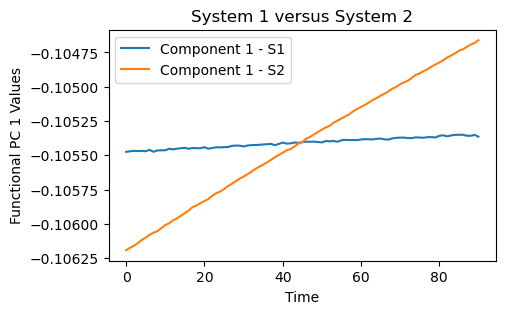

alt.VConcatChart(...)

In [45]:
pc_scores_s1_B_cal_window, pc_scores_s2_B_cal_window,fpca_s1_B_cal_window,fpca_s2_B_cal_window = fpca_two_inputs(B1_cal_window, B2_cal_window)
create_pc_scores_plots(pc_scores_s1_B_cal_window, pc_scores_s2_B_cal_window, B1_Merged, B2_Merged)

### System 1 versus System 2: Sensor B - Sample Window

S1 Explain variance PC1 (%):  99.99894561603622
S2 Explain variance PC1 (%):  99.99938675502452


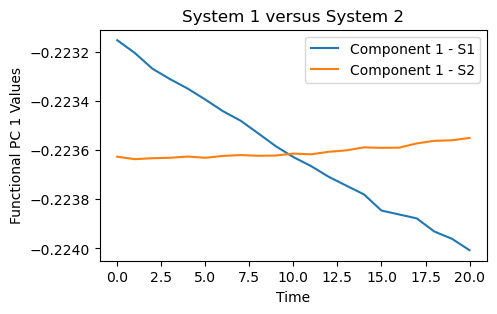

alt.VConcatChart(...)

In [46]:
pc_scores_s1_B_sample_window, pc_scores_s2_B_sample_window,fpca_s1_B_sample_window,fpca_s2_B_sample_window = fpca_two_inputs(B1_sample_window, B2_sample_window)
create_pc_scores_plots(pc_scores_s1_B_sample_window, pc_scores_s2_B_sample_window, B1_Merged, B2_Merged)

## 8.3 Linear Regression

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     4460.
Date:                Thu, 06 Jun 2024   Prob (F-statistic):           5.24e-24
Time:                        17:15:21   Log-Likelihood:                 201.17
No. Observations:                  21   AIC:                            -398.3
Df Residuals:                      19   BIC:                            -396.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2232   7.41e-06  -3.01e+04      0.0

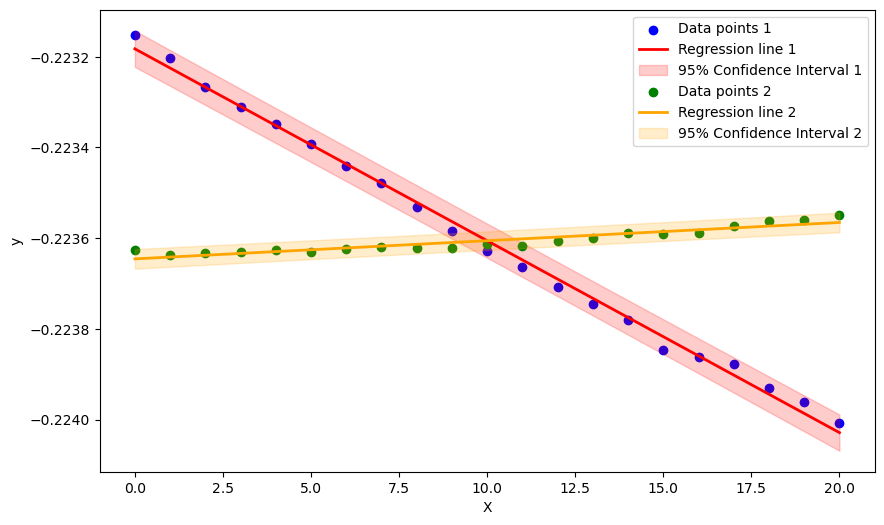

In [47]:
import statsmodels.api as sm

# Assume you already have data for x1, y1, x2, and y2
x1 = fpca_s1_B_sample_window.grid_points[0]
y1 = fpca_s1_B_sample_window.data_matrix[0].flatten()
x2 = fpca_s2_B_sample_window.grid_points[0]
y2 = fpca_s2_B_sample_window.data_matrix[0].flatten()

# Add a constant to the feature variables
x1_with_const = sm.add_constant(x1)
x2_with_const = sm.add_constant(x2)

# Create and fit a linear regression model for x1 and y1
model1 = sm.OLS(y1, x1_with_const).fit()

# Create and fit a linear regression model for x2 and y2
model2 = sm.OLS(y2, x2_with_const).fit()

# Output detailed summary of the models
summary1 = model1.summary()
summary2 = model2.summary()
print(summary1)
print(summary2)

# Extract predicted values from the models
y1_pred = model1.predict(x1_with_const)
y2_pred = model2.predict(x2_with_const)

# Compute confidence intervals
pred1 = model1.get_prediction(x1_with_const)
pred_summary1 = pred1.summary_frame(alpha=0.05)  # 95% confidence interval
ci_lower1 = pred_summary1['obs_ci_lower']
ci_upper1 = pred_summary1['obs_ci_upper']

pred2 = model2.get_prediction(x2_with_const)
pred_summary2 = pred2.summary_frame(alpha=0.05)  # 95% confidence interval
ci_lower2 = pred_summary2['obs_ci_lower']
ci_upper2 = pred_summary2['obs_ci_upper']

# Visualize the results
plt.figure(figsize=(10, 6))

# Plot results for the first set of data
plt.scatter(x1, y1, color='blue', label='Data points 1')
plt.plot(x1, y1_pred, color='red', linewidth=2, label='Regression line 1')
plt.fill_between(x1, ci_lower1, ci_upper1, color='red', alpha=0.2, label='95% Confidence Interval 1')

# Plot results for the second set of data
plt.scatter(x2, y2, color='green', label='Data points 2')
plt.plot(x2, y2_pred, color='orange', linewidth=2, label='Regression line 2')
plt.fill_between(x2, ci_lower2, ci_upper2, color='orange', alpha=0.2, label='95% Confidence Interval 2')

plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


# 9. Functional Regression

## Define useful function

In [48]:
def Function_regression(windows, Merge_dataset, len_time=40, predictor=["AmbientTemperature", "AgeOfCardInDaysAtTimeOfTest"]):
    """
    Perform functional regression using the given data.

    Parameters:
    windows (DataFrame): The dataset containing the time series data.
    Merge_dataset (DataFrame): The dataset containing the predictors.
    len_time (int): The number of basis functions to use for the Fourier basis. Default is 40.
    predictor (list): The list of predictor variables to use in the regression. Default includes 'AmbientTemperature' and 'AgeOfCardInDaysAtTimeOfTest'.

    Returns:
    funct_reg (LinearRegression): The fitted linear regression model.
    """

    # Prepare Data
    # Transform the time series data into a list
    merged_column = [list(row) for row in windows.iloc[:, :].to_numpy()]

    # Convert the list to functional data object with Fourier basis
    Y = FDataGrid(merged_column, grid_points=range(len(merged_column[1])))
    basis = FourierBasis(n_basis=len_time)
    y = Y.coordinates[0].to_basis(basis)

    # Prepare the predictor data
    x = Merge_dataset.loc[:, predictor]

    # Fit the linear regression model
    funct_reg = LinearRegression(fit_intercept=True)
    funct_reg.fit(x, y)

    # Print model summary
    print("To check if we need to move any time stamp", "\n")
    intercept = funct_reg.intercept_
    print("The intercept of this model is:", intercept, "\n")
    for i in range(len(predictor)):
        coef = funct_reg.coef_[i]
        print("The coefficient of {} of this model is: {}".format(predictor[i], coef), "\n")

    return funct_reg


In [49]:
def coefficent_visualization(funct_reg, funct_reg2, predictor, interval, title):
    """
    Visualize the coefficients of two functional regression models over a specified interval.

    Parameters:
    funct_reg (LinearRegression): The first fitted linear regression model.
    funct_reg2 (LinearRegression): The second fitted linear regression model.
    predictor (list): The list of predictor variables.
    interval (slice): The slice object representing the interval of interest for the coefficients.
    title (str): The title for the overall plot.

    Returns:
    None: This function displays the plots of the coefficients.
    """
    num_predictors = len(predictor)
    num_intervals = len(funct_reg.intercept_.coefficients[0][interval])

    fig, axs = plt.subplots(num_predictors + 1, 1, figsize=(8, 6*num_predictors))

    # Set the overall title for the figure
    fig.suptitle(title, fontsize=16)

    # Plot the intercepts for both systems
    axs[0].plot(np.arange(num_intervals), funct_reg.intercept_.coefficients[0][interval], label='Intercept in system 1')
    axs[0].plot(np.arange(num_intervals), funct_reg2.intercept_.coefficients[0][interval], label='Intercept in system 2')
    axs[0].legend()
    axs[0].set_title('Intercept')

    # Plot the coefficients for each predictor
    for i in range(num_predictors):
        axs[i + 1].plot(np.arange(num_intervals), funct_reg.coef_[i].coefficients[0][interval], label='Coefficient in system 1')
        axs[i + 1].plot(np.arange(num_intervals), funct_reg2.coef_[i].coefficients[0][interval], label='Coefficient in system 2')
        axs[i + 1].legend()
        axs[i + 1].set_title(predictor[i])

    # Adjust the layout to make room for the title
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


## Regression result

This is the coeffcient from the output of the model.
Because of the different magnitude, we need to choose which time stamps will we visualize

### Cal window

#### Sensor A

##### General

In [50]:
print("System 1:")
A1_cal_window_funct_reg = Function_regression(A1_cal_window,A1_Merged_balanced,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
A2_cal_window_funct_reg = Function_regression(A2_cal_window,A2_Merged_balanced,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])

System 1:
To check if we need to move any time stamp 

The intercept of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 40.0),), n_basis=41, period=40.0),
    coefficients=[[ 2.39438548e+02 -6.29715899e-01  7.07119646e-02  6.54764394e-04
       2.26097874e-01 -3.48349832e-01  4.08721458e-01  1.99118558e-01
       1.22170385e-01  9.47668762e-02 -1.07347438e-01 -2.64689078e-01
      -6.15059035e-02 -3.38519283e-02  3.49680113e-01 -7.91147324e-01
      -1.43220105e-02 -8.01124600e-01  4.62880762e-01 -1.01438341e+00
       6.33375121e-01  5.97222633e-01 -2.81490406e-01 -5.64011391e-01
      -2.90546621e-01 -1.44986208e-01 -1.19162961e-01  2.94669932e-01
       3.07722358e-01 -7.92299971e-02  8.46104868e-01  3.79960225e-01
       2.30487512e-01  3.17088267e-01 -2.06360249e-01 -6.19808092e-01
       1.84999593e-01 -7.54885305e-01 -6.04337969e-01 -1.15521455e+14
      -1.27066170e-01]]) 

The coefficient of AmbientTemperature of this model is: FDataBasis(
    _basis=Fou

#### Sensor B

##### General

In [51]:
print("System 1:")
B1_cal_window_funct_reg = Function_regression(B1_cal_window,B1_Merged_balanced,90,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
B2_cal_window_funct_reg = Function_regression(B2_cal_window,B2_Merged_balanced,90,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])


System 1:
To check if we need to move any time stamp 

The intercept of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 90.0),), n_basis=91, period=90.0),
    coefficients=[[-2.58857623e+03  1.22392853e+00 -5.26061545e+00  2.97621188e+00
      -8.30029798e+00 -1.76929514e+01 -1.96217753e-01  8.59029216e+00
       5.20688091e+00 -6.99390887e+00  8.86183761e+00 -2.59936188e+00
      -1.65591269e+01  2.69442049e+00  8.58869162e+00 -1.53235838e+01
      -8.31606270e+00  9.27565490e+00 -6.16620896e+00 -4.17524781e+00
      -2.63789266e+01 -6.75688222e+00  2.59036466e+01 -1.90703243e+01
      -1.51454110e+00 -8.36061007e+00 -6.27921074e+00  6.73152729e+00
      -8.01423280e+00 -4.13639110e+00 -1.22652825e+01  2.92765152e+01
       2.38831282e+01  1.01779465e+01  5.08585684e+00  8.88050132e+00
       3.28952833e+01 -7.48838245e+00  1.26044424e+01  8.78648298e+00
       4.25785508e+01  1.72680343e+01 -2.70651934e-01 -9.45149136e+00
       1.74008452e+00 -3.21576321e+01 -

### Sample window

#### Sensor A

##### General

In [52]:
print("System 1:")
A1_sample_window_funct_reg = Function_regression(A1_sample_window,A1_Merged_balanced,25,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
A2_sample_window_funct_reg = Function_regression(A2_sample_window,A2_Merged_balanced,25,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])


System 1:
To check if we need to move any time stamp 

The intercept of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 25.0),), n_basis=25, period=25.0),
    coefficients=[[ 2.11934203e+02  1.42474116e-01  1.31135216e-02  7.98292957e-02
       6.76626530e-03  3.66145655e-02 -3.02754470e-03  2.94400846e-02
      -2.56626091e-04  2.94115749e-02 -5.17564435e-03  2.38169892e-02
      -4.12668941e-03  8.91558876e-03  1.25291526e-03  9.55279505e-03
      -1.83431533e-04 -3.71051414e-04 -2.90687838e-03  1.73716793e-03
      -2.04386862e-03  9.92888630e-03 -4.74743442e-03  3.04170677e-03
      -2.41415554e-03]]) 

The coefficient of AmbientTemperature of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 25.0),), n_basis=25, period=25.0),
    coefficients=[[-2.60747741e+00  4.17917175e-03  2.02503395e-05  1.84649492e-03
      -1.13316569e-04  1.72197935e-03  2.07398045e-04  1.11963522e-03
       6.38569629e-05  5.27045337e-04  3.39273367e-04  4.11137

#### Sensor B

##### General

In [53]:
print("System 1:")
B1_sample_window_funct_reg = Function_regression(B1_sample_window,B1_Merged_balanced,20,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
B2_sample_window_funct_reg = Function_regression(B2_sample_window,B2_Merged_balanced,20,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])


System 1:
To check if we need to move any time stamp 

The intercept of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 20.0),), n_basis=21, period=20.0),
    coefficients=[[-1.09811987e+03 -3.79744898e+00  8.27888579e-01  1.37807539e+00
       7.74881413e-01  1.24542120e+00 -2.13680712e-04  4.26728183e+00
      -1.73255444e-01 -2.76800410e+00  1.38114273e+00 -2.32077044e+00
      -2.46290189e+00 -3.57419204e+00  2.53056039e+00  8.33989689e-01
      -3.72490689e+00 -3.25497917e+00 -7.60718491e-01 -1.59055177e+15
      -2.74152036e+00]]) 

The coefficient of AmbientTemperature of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 20.0),), n_basis=21, period=20.0),
    coefficients=[[-1.09066825e+00  1.20362338e-01 -3.73182212e-02 -7.02868467e-02
      -1.79346702e-02 -6.31158980e-02 -2.93273585e-03 -1.87483022e-01
       5.04768335e-02  2.43888574e-02 -5.07064571e-02  8.14502242e-02
       5.22590311e-02  1.35658517e-01 -1.07402394e-01 -5.85240

## Visulize coefficients


### Cal window

#### Sensor A


As the result show above, the value at time point 39 is of the exponent of 14,
which is significantly greater than the rest of the data. And the first time point is also larger than others
* Same case in both systems.
* Same case in different Fluid Type

So for the convenience of visualization, we remove these points.

##### General

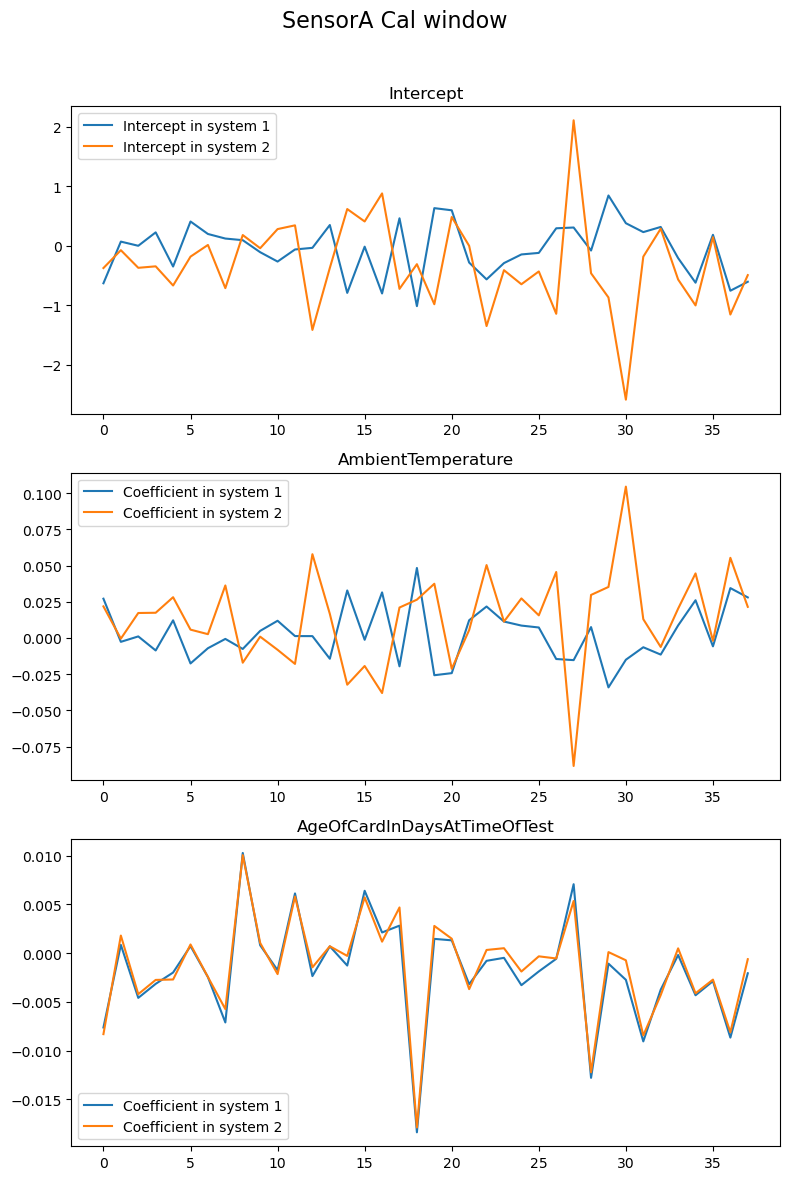

In [54]:
coefficent_visualization(A1_cal_window_funct_reg,A2_cal_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],range(1,39),"SensorA Cal window")


#### Sensor B

##### General

As the result show above, the value at time point 89 way higher than others. And also the first time point is also larger than others; Same case in both systems. So for the convenience of visualization, we remove these points.



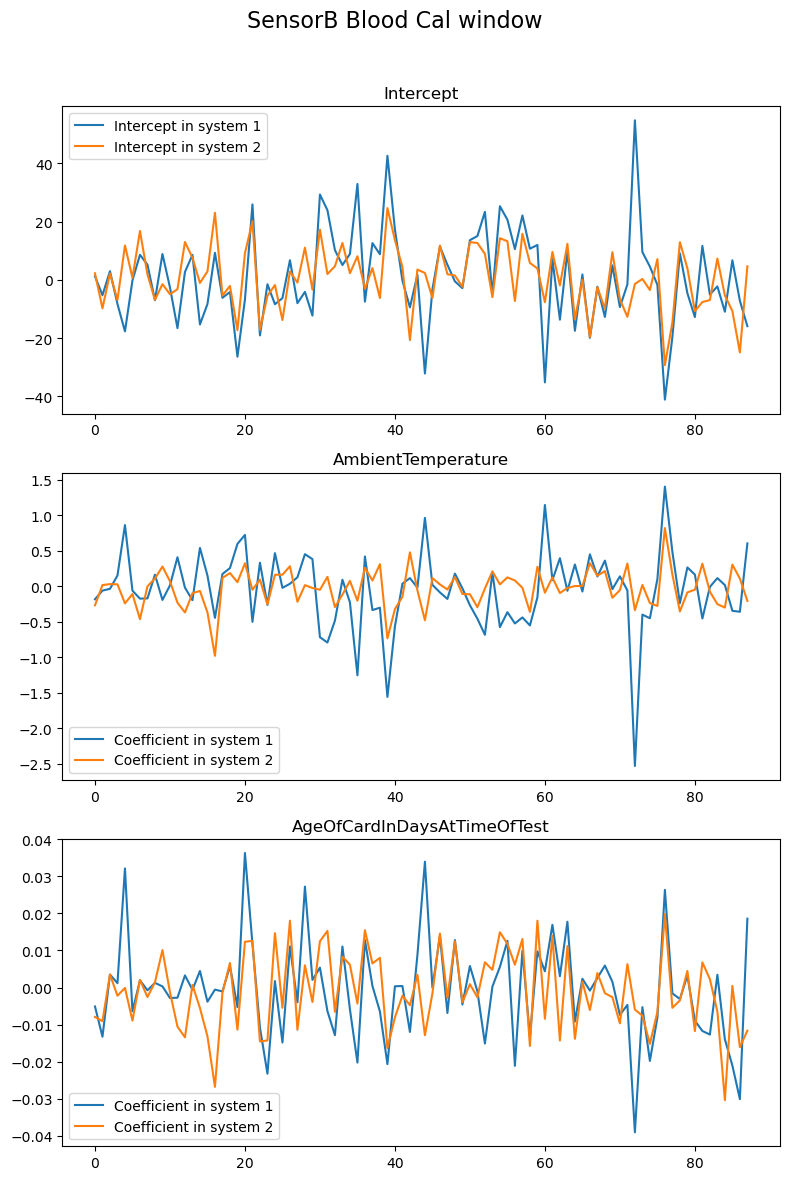

In [55]:
coefficent_visualization(B1_cal_window_funct_reg,B2_cal_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],range(1,89),"SensorB Blood Cal window")


### Sample window

#### Sensor A


As the result show above, The first time point is also larger than others
* Same case in both systems.
* Same case in different Fluid Type

So for the convenience of visualization, we remove this point.

##### General

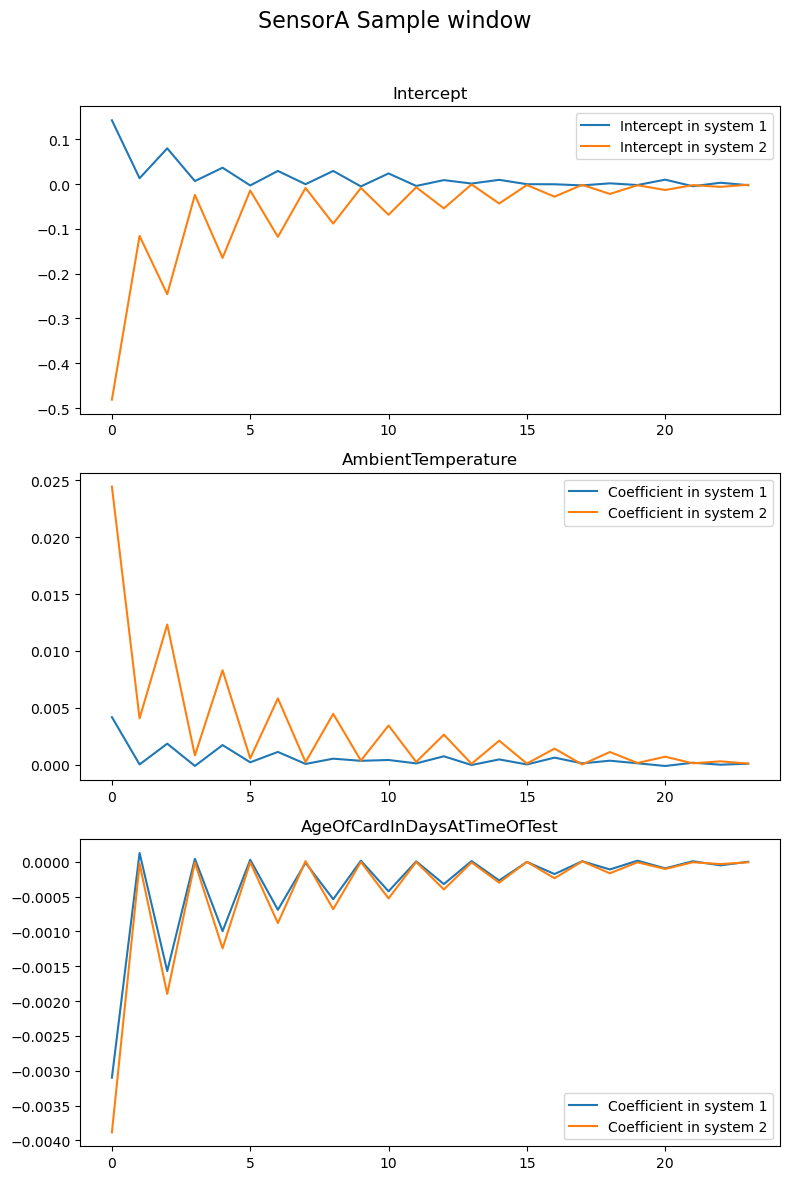

In [56]:
coefficent_visualization(A1_sample_window_funct_reg, A2_sample_window_funct_reg, ["AmbientTemperature", "AgeOfCardInDaysAtTimeOfTest"], range(1,25), "SensorA Sample window")


#### Sensor B

As the result show above, the value at time point 19 is significantly greater than the rest of the data. And the first time point is also larger than others;

Same case in both systems. So for the convenience of visualization, we remove these points.



##### General

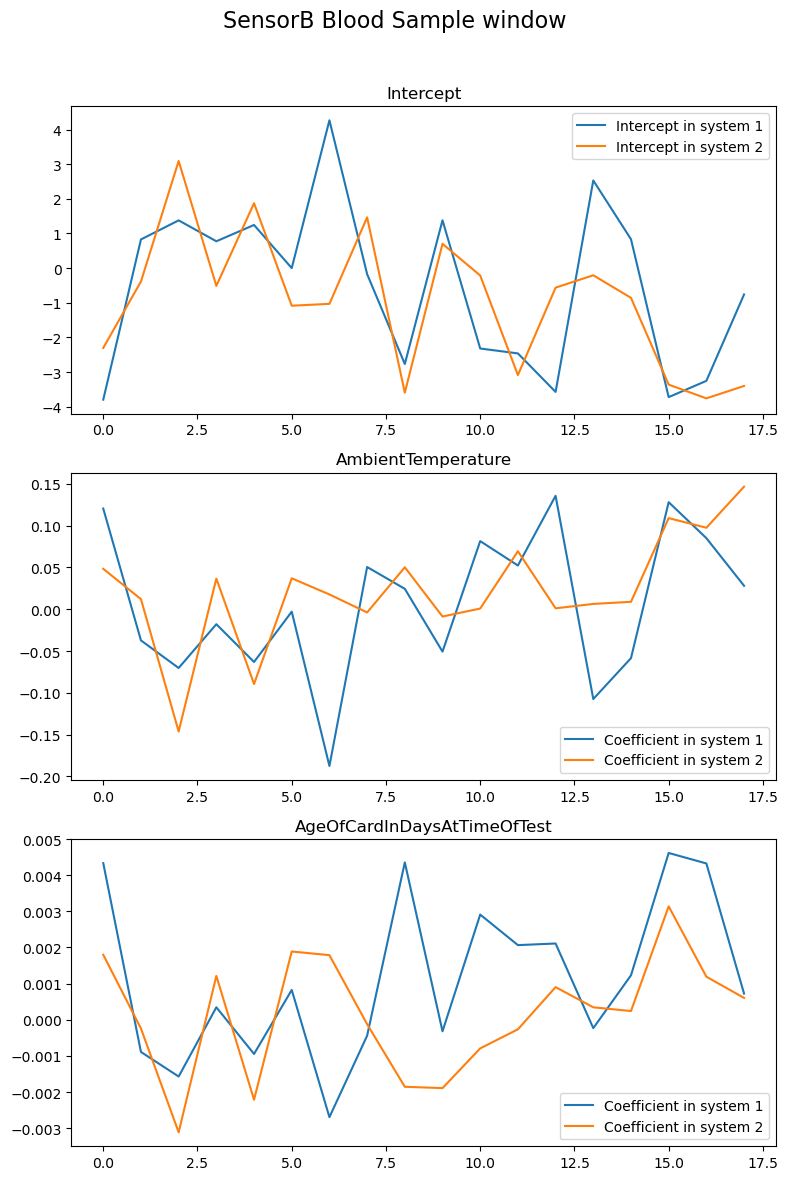

In [57]:
coefficent_visualization(B1_sample_window_funct_reg, B2_sample_window_funct_reg, ["AmbientTemperature", "AgeOfCardInDaysAtTimeOfTest"], range(1, 19), "SensorB Blood Sample window")